# MVPA and Searchlight with `nilearn` and `PyMVPA`

In this section we will show how you can use two different machine learning toolboxes, `nilearn` and `PyMVPA`, to perform multi-variate pattern analysis (MVPA) and Searchlight analysis.


## `nilearn`

Although nilearn's visualizations are quite nice, its primary purpose was to facilitate machine learning in neuroimaging. It's in some sense the bridge between [nibabel](http://nipy.org/nibabel/) and [scikit-learn](http://scikit-learn.org/stable/). On the one hand, it reformats images to be easily passed to scikit-learn, and on the other, it reformats the results to produce valid nibabel images.

So let's take a look at a short multi-variate pattern analysis (MVPA) example.

**Note 1**: This section is heavily based on the [nilearn decoding tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html).  
**Note 2**: This section is not intended to teach machine learning, but to demonstrate a simple nilearn pipeline.

## Setup

In [1]:
from nilearn import plotting
%matplotlib inline
import numpy as np
import nibabel as nb

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load machine learning dataset

Let's load the dataset we prepared in the previous notebook:

In [2]:
func = '/home/neuro/notebooks/data/dataset_ML.nii.gz'
!nib-ls $func

/home/neuro/notebooks/data/dataset_ML.nii.gz float32 [ 40,  51,  41, 384] 4.00x4.00x4.00x1.00



## Create mask

As we only want to use voxels in a particular region of interest (ROI) for the classification, let's create a function that returns a mask that either contains the only the brain, only the eyes or both:

In [3]:
from nilearn.image import resample_to_img, math_img
from scipy.ndimage import binary_dilation

def get_mask(mask_type):
    
    # Specify location of the brain and eye image
    brain = '/templates/MNI152_T1_1mm_brain.nii.gz'
    eyes = '/templates/MNI152_T1_1mm_eye.nii.gz'

    # Load region of interest
    if mask_type == 'brain':
        img_resampled = resample_to_img(brain, func)
    elif mask_type == 'eyes':
        img_resampled = resample_to_img(eyes, func)
    elif mask_type == 'both':
        img_roi = math_img("img1 + img2", img1=brain, img2=eyes)
        img_resampled = resample_to_img(img_roi, func)

    # Binarize ROI template
    data_binary = np.array(img_resampled.get_data()>=10, dtype=np.int8)

    # Dilate binary mask once
    data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

    # Save binary mask in NIfTI image
    mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
    mask.set_data_dtype('i1')
    
    return mask

## Masking and Un-masking data

For the classification with `nilearn` we need our functional data in a 2D, sample-by-voxel matrix. To get that, we'll select all the voxels defined in our `mask`.

In [4]:
from nilearn.plotting import plot_roi

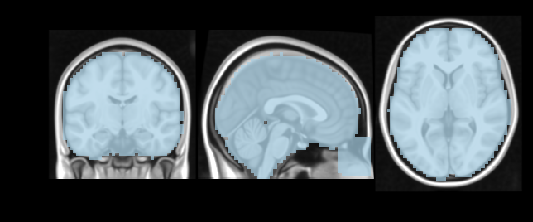

In [5]:
anat = '/templates/MNI152_T1_1mm.nii.gz'
mask = get_mask('both')
plot_roi(mask, anat, cmap='Paired', dim=-.5, draw_cross=False, annotate=False)

`NiftiMasker` is an object that applies a mask to a dataset and returns the masked voxels as a vector at each time point.

In [6]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)
print(samples)

[[0.7965089  0.9749323  0.9000536  ... 0.56139576 0.40530768 0.71668595]
 [0.9088199  0.7303408  0.63435954 ... 0.80835986 0.44824055 0.46237826]
 [0.6761813  0.8293086  0.9835918  ... 0.5358669  0.56062424 0.72024435]
 ...
 [0.81860083 0.8177914  1.0595632  ... 0.63843036 0.5614186  0.7092098 ]
 [0.8739697  0.6019776  1.0053024  ... 0.5492817  0.67479044 0.70944095]
 [0.8174745  0.9999173  0.9347665  ... 0.6070517  0.92529875 0.7956351 ]]


Its shape corresponds to the number of time-points times the number of voxels in the mask.

In [7]:
print(samples.shape)

(384, 37398)


To recover the original data shape (giving us a masked and z-scored BOLD series), we simply use the masker's inverse transform:

In [8]:
masked_epi = masker.inverse_transform(samples)

Let's now visualize the masked epi.

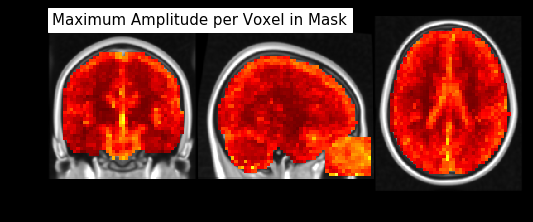

In [9]:
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, bg_img=anat, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

# Simple MVPA Example

Multi-voxel pattern analysis (MVPA) is a general term for techniques that contrast conditions over multiple voxels. It's very common to use machine learning models to generate statistics of interest.

In this case, we'll use the response patterns of voxels in the mask to predict if the eyes were **closed** or **open** during a resting-state fMRI recording. But before we can do MVPA, we still need to specify two important parameters:

***First***, we need to know the label for each volume. From the last section of the [Machine Learning Preparation](machine_learning_preparation.ipynb) notebook, we know that we have a total of 384 volumes in our `dataset_ML.nii.gz` file and that it's always 4 volumes of the condition `eyes closed`, followed by 4 volumes of the condition `eyes open`, etc. Therefore our labels should be as follows:

In [10]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

***Second***, we need the `chunks` parameter. This variable is important if we want to do for example cross-validation. In our case we would ideally create 48 chunks, one for each subject. But because a cross-validation of 48 chunks takes very long, let's just create 6 chunks, containing always 8 subjects, i.e. 64 volumes:

In [11]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

One way to do cross-validation is the so called **Leave-one-out cross-validation**. This approach trains on `(n - 1)` chunks, and classifies the remaining chunk, and repeats this for every chunk, also called **fold**. Therefore, a 6-fold cross-validation is one that divides the whole data into 6 different chunks.

Now that we have the labels and chunks ready, we're only missing the classifier. In `Scikit-Learn`, there are [many to choose from](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html), let's start with the most well known, a linear support vector classifier (SVC).

In [12]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=25)

**Note:** The number of maximum iterations should ideally be much much bigger (around 1000), but was kept low here to reduce computation time.

Now, we're ready to train the classifier and do the cross-validation.

In [13]:
# Performe the cross validation (takes time to compute)
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.9s finished


After the cross validation was computed we can extract the overall accuracy, as well as the accuracy for each individual fold (i.e. leave-one-out prediction). Mean (across subject) cross-validation accuracy is a common statistic for classification-based MVPA.

In [14]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 83.07 percent

Accuracy per fold:
[0.8125   0.75     0.765625 0.875    0.90625  0.875   ]


**Wow, an average accuracy above 80%!!!** What if we use another classifer? Let's say a Gaussian Naive Bayes classifier?

In [15]:
# Let's specify a Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [16]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=1,
                            verbose=1)

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s finished


In [17]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 79.43 percent

Accuracy per fold:
[0.75     0.796875 0.796875 0.796875 0.875    0.75    ]


That was much quicker, but less accurate. As was expected. What about a Logistic Regression classifier?

In [18]:
# Let's specify a Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=25)

In [19]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   17.9s finished


In [20]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 85.16 percent

Accuracy per fold:
[0.828125 0.8125   0.8125   0.890625 0.875    0.890625]


The predictino accuracy is again above **80%**, much better! But anyhow, how do we know if an accuracy value is significant or not? Well, one way to find this out is to do some permutation testing.

## Permutation testing

One way to test the quality of the prediction accuracy is to run the cross-validation multiple times, but permutate the labels of the volumes randomly. Afterwards we can compare the accuracy value of the correct labels to the ones with the random / false labels. Luckily `Scikit-learn` already has a function that does this for us. So let's do it.

**Note**: We chose again the `GaussianNB` classifier to reduce the computation time per cross-validation. Additionally, we chose the number of iterations under `n_permutations` for the permutation testing very low, to reduce computation time as well. This value should ideally be much higher, at least 100.

In [21]:
# Let's chose again the linear SVC
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [22]:
# Import the permuation function
from sklearn.model_selection import permutation_test_score

In [23]:
# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=25,
                                        n_jobs=-1,
                                        verbose=1)

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished


So, let's take a look at the results:

In [24]:
print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

Prediction accuracy: 79.43
p-value: 0.0385


Great! This means... Using resting-state fMRI images, we can predict if a person had their eyes open or closed with an accuracy significantly above chance level!

# Which region is driving the classification?

With a simple MVPA approach we unfortunately don't know which regions are driving the classification accuracy. We just know that all voxels in the mask allow the classification of the two classes, but why? We need a better technique that tells us where in the head we should look.

There are many different ways to figure out which region is important for classification, but let us introdcue you two two different approaches that you can use in `nilearn`: `SpaceNet` and  `Searchlight`

## SpaceNet: decoding with spatial structure for better maps

SpaceNet implements spatial penalties which improve brain decoding power as well as decoder maps. The results are brain maps which are both sparse (i.e regression coefficients are zero everywhere, except at predictive voxels) and structured (blobby). For more detail, check out `nilearn`'s section about [SpaceNet](http://nilearn.github.io/decoding/space_net.html).

To train a SpaceNet on our data, let's first split the data into a training set (chunk 0-4) and a test set (chunk 5). 

In [25]:
# Create two masks that specify the training and the test set 
mask_test = chunks == 5
mask_train = np.invert(mask_test)

In [26]:
# Apply this sample mask to X (fMRI data) and y (behavioral labels)
from nilearn.image import index_img
X_train = index_img(func, mask_train)
y_train = labels[mask_train]

X_test = index_img(func, mask_test)
y_test = labels[mask_test]

Now we can fit the SpaceNet to our data with a TV-l1 penalty. ***Note*** again, that we reduced the number of `max_iter` to have a quick computation. In a realistic case this value should be around 1000.

In [27]:
from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=get_mask('both'),
                             max_iter=10,
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(X_train, y_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 320),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/decoding/space_net.py:835: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f6d33cfa9d8>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 64, ..., 319]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=15.268555470880802)


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/decoding/objective_functions.py:209: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gradient[slice_all] = np.diff(img, axis=d)


______________________________________________________path_scores - 5.1s, 0.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f6d33cfa9d8>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 319]), array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1,

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.2s finished


SpaceNetClassifier(alphas=None, cv=5, debias=False, eps=0.001,
          fit_intercept=True, high_pass=None, l1_ratios=0.5,
          loss='logistic', low_pass=None,
          mask=<nibabel.nifti1.Nifti1Image object at 0x7f6d33d70e48>,
          max_iter=10, memory=Memory(cachedir='nilearn_cache/joblib'),
          memory_level=2, n_alphas=10, n_jobs=1, penalty='tv-l1',
          screening_percentile=20.0, standardize=True, t_r=None,
          target_affine=None, target_shape=None, tol=0.0001, verbose=1)

Now that the `SpaceNet` is fitted to the training data. Let's see how well it does in predicting the test data.

In [28]:
# Predict the labels of the test data
y_pred = decoder.predict(X_test)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 64),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [29]:
# Retrun average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)


TV-l1  classification accuracy : 85.9375%


Again above 80% prediction accuracy? But we wanted to know what's driving this prediction. So let's take a look at the fitting coefficients.

In [30]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

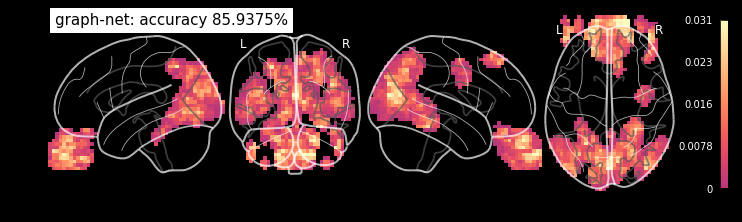

In [31]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

Cool! As expected the visual cortex (in the back of the head) and the eyes are driving the classification!

## Searchlight

Now the next question is: How high would the prediction accuracy be if we only take one small region to do the classification?

To answer this question we can use something that is called a **Searchlight** approach. The searchlight approach was first proposed by [Kriegeskorte et al., 2006](https://pdfs.semanticscholar.org/985c/ceaca8606443f9129616a26bbbbf952f2d7f.pdf). It is a widely used approach for the study of the fine-grained patterns of information in fMRI analysis. Its principle is relatively simple: a small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation.

You can do a searchlight analysis in `nilearn` as follows:

In [32]:
from nilearn.decoding import SearchLight

In [33]:
# Specify the mask in which the searchlight should be performed
mask = get_mask('both')

In [34]:
# Specify the classifier to use
# Let's use again a GaussainNB classifier to reduce computation time
clf = GaussianNB()

In [35]:
# Specify the radius of the searchlight sphere  that will scan the volume
# (the bigger the longer the computation)
sphere_radius = 8  # in mm

Now we're ready to create the searchlight object.

In [36]:
# Create searchlight object
sl = SearchLight(mask,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=-1,
                 verbose=1)

In [37]:
# Run the searchlight algorithm
sl.fit(nb.load(func), labels, groups=chunks)

Job #1, processed 0/4675 voxels (0.00%, 114 seconds remaining)
Job #1, processed 10/4675 voxels (0.21%, 52 seconds remaining)
Job #2, processed 0/4675 voxels (0.00%, 122 seconds remaining)
Job #1, processed 20/4675 voxels (0.43%, 42 seconds remaining)
Job #2, processed 10/4675 voxels (0.21%, 57 seconds remaining)
Job #3, processed 0/4675 voxels (0.00%, 90 seconds remaining)
Job #1, processed 30/4675 voxels (0.64%, 39 seconds remaining)
Job #3, processed 10/4675 voxels (0.21%, 49 seconds remaining)
Job #2, processed 20/4675 voxels (0.43%, 49 seconds remaining)
Job #1, processed 40/4675 voxels (0.86%, 38 seconds remaining)
Job #4, processed 0/4675 voxels (0.00%, 135 seconds remaining)
Job #1, processed 50/4675 voxels (1.07%, 37 seconds remaining)
Job #3, processed 20/4675 voxels (0.43%, 47 seconds remaining)
Job #2, processed 30/4675 voxels (0.64%, 49 seconds remaining)
Job #5, processed 0/4675 voxels (0.00%, 119 seconds remaining)
Job #1, processed 60/4675 voxels (1.28%, 37 seconds rema

Job #8, processed 120/4674 voxels (2.57%, 60 seconds remaining)
Job #5, processed 160/4675 voxels (3.42%, 56 seconds remaining)
Job #2, processed 180/4675 voxels (3.85%, 58 seconds remaining)
Job #4, processed 160/4675 voxels (3.42%, 60 seconds remaining)
Job #7, processed 130/4674 voxels (2.78%, 63 seconds remaining)
Job #3, processed 180/4675 voxels (3.85%, 57 seconds remaining)
Job #6, processed 140/4675 voxels (2.99%, 64 seconds remaining)
Job #8, processed 130/4674 voxels (2.78%, 60 seconds remaining)
Job #1, processed 230/4675 voxels (4.92%, 49 seconds remaining)
Job #5, processed 170/4675 voxels (3.64%, 56 seconds remaining)
Job #2, processed 190/4675 voxels (4.06%, 58 seconds remaining)
Job #7, processed 140/4674 voxels (3.00%, 62 seconds remaining)
Job #3, processed 190/4675 voxels (4.06%, 56 seconds remaining)
Job #4, processed 170/4675 voxels (3.64%, 61 seconds remaining)
Job #6, processed 150/4675 voxels (3.21%, 63 seconds remaining)
Job #8, processed 140/4674 voxels (3.00%

Job #5, processed 320/4675 voxels (6.84%, 55 seconds remaining)
Job #8, processed 280/4674 voxels (5.99%, 58 seconds remaining)
Job #7, processed 290/4674 voxels (6.20%, 59 seconds remaining)
Job #3, processed 350/4675 voxels (7.49%, 54 seconds remaining)
Job #6, processed 290/4675 voxels (6.20%, 61 seconds remaining)
Job #2, processed 350/4675 voxels (7.49%, 56 seconds remaining)
Job #4, processed 320/4675 voxels (6.84%, 58 seconds remaining)
Job #1, processed 390/4675 voxels (8.34%, 51 seconds remaining)
Job #5, processed 330/4675 voxels (7.06%, 55 seconds remaining)
Job #8, processed 290/4674 voxels (6.20%, 58 seconds remaining)
Job #3, processed 360/4675 voxels (7.70%, 54 seconds remaining)
Job #7, processed 300/4674 voxels (6.42%, 59 seconds remaining)
Job #4, processed 330/4675 voxels (7.06%, 58 seconds remaining)
Job #2, processed 360/4675 voxels (7.70%, 55 seconds remaining)
Job #6, processed 300/4675 voxels (6.42%, 61 seconds remaining)
Job #1, processed 400/4675 voxels (8.56%

Job #2, processed 510/4675 voxels (10.91%, 55 seconds remaining)
Job #5, processed 460/4675 voxels (9.84%, 59 seconds remaining)
Job #6, processed 460/4675 voxels (9.84%, 58 seconds remaining)
Job #1, processed 540/4675 voxels (11.55%, 53 seconds remaining)
Job #3, processed 510/4675 voxels (10.91%, 55 seconds remaining)
Job #7, processed 450/4674 voxels (9.63%, 59 seconds remaining)
Job #2, processed 520/4675 voxels (11.12%, 55 seconds remaining)
Job #4, processed 490/4675 voxels (10.48%, 57 seconds remaining)
Job #8, processed 450/4674 voxels (9.63%, 58 seconds remaining)
Job #5, processed 470/4675 voxels (10.05%, 59 seconds remaining)
Job #6, processed 470/4675 voxels (10.05%, 58 seconds remaining)
Job #1, processed 550/4675 voxels (11.76%, 53 seconds remaining)
Job #3, processed 520/4675 voxels (11.12%, 55 seconds remaining)
Job #2, processed 530/4675 voxels (11.34%, 55 seconds remaining)
Job #7, processed 460/4674 voxels (9.84%, 59 seconds remaining)
Job #8, processed 460/4674 vox

Job #2, processed 660/4675 voxels (14.12%, 57 seconds remaining)
Job #3, processed 680/4675 voxels (14.55%, 54 seconds remaining)
Job #4, processed 630/4675 voxels (13.48%, 59 seconds remaining)
Job #1, processed 710/4675 voxels (15.19%, 53 seconds remaining)
Job #6, processed 620/4675 voxels (13.26%, 59 seconds remaining)
Job #8, processed 610/4674 voxels (13.05%, 58 seconds remaining)
Job #5, processed 630/4675 voxels (13.48%, 59 seconds remaining)
Job #4, processed 640/4675 voxels (13.69%, 59 seconds remaining)
Job #2, processed 670/4675 voxels (14.33%, 57 seconds remaining)
Job #7, processed 600/4674 voxels (12.84%, 61 seconds remaining)
Job #1, processed 720/4675 voxels (15.40%, 53 seconds remaining)
Job #3, processed 690/4675 voxels (14.76%, 55 seconds remaining)
Job #8, processed 620/4674 voxels (13.26%, 58 seconds remaining)
Job #6, processed 630/4675 voxels (13.48%, 59 seconds remaining)
Job #2, processed 680/4675 voxels (14.55%, 57 seconds remaining)
Job #3, processed 700/467

Job #1, processed 870/4675 voxels (18.61%, 54 seconds remaining)
Job #5, processed 770/4675 voxels (16.47%, 61 seconds remaining)
Job #4, processed 800/4675 voxels (17.11%, 59 seconds remaining)
Job #3, processed 850/4675 voxels (18.18%, 56 seconds remaining)
Job #6, processed 770/4675 voxels (16.47%, 61 seconds remaining)
Job #2, processed 820/4675 voxels (17.54%, 59 seconds remaining)
Job #7, processed 750/4674 voxels (16.05%, 62 seconds remaining)
Job #5, processed 780/4675 voxels (16.68%, 61 seconds remaining)
Job #1, processed 880/4675 voxels (18.82%, 55 seconds remaining)
Job #4, processed 810/4675 voxels (17.33%, 59 seconds remaining)
Job #8, processed 780/4674 voxels (16.69%, 59 seconds remaining)
Job #6, processed 780/4675 voxels (16.68%, 61 seconds remaining)
Job #5, processed 790/4675 voxels (16.90%, 61 seconds remaining)
Job #4, processed 820/4675 voxels (17.54%, 59 seconds remaining)
Job #2, processed 830/4675 voxels (17.75%, 59 seconds remaining)
Job #3, processed 860/467

Job #4, processed 960/4675 voxels (20.53%, 58 seconds remaining)
Job #3, processed 990/4675 voxels (21.18%, 56 seconds remaining)
Job #8, processed 940/4674 voxels (20.11%, 57 seconds remaining)
Job #7, processed 910/4674 voxels (19.47%, 60 seconds remaining)
Job #1, processed 1030/4675 voxels (22.03%, 54 seconds remaining)
Job #5, processed 940/4675 voxels (20.11%, 59 seconds remaining)
Job #2, processed 980/4675 voxels (20.96%, 57 seconds remaining)
Job #6, processed 920/4675 voxels (19.68%, 60 seconds remaining)
Job #4, processed 970/4675 voxels (20.75%, 58 seconds remaining)
Job #3, processed 1000/4675 voxels (21.39%, 56 seconds remaining)
Job #7, processed 920/4674 voxels (19.68%, 60 seconds remaining)
Job #8, processed 950/4674 voxels (20.33%, 57 seconds remaining)
Job #1, processed 1040/4675 voxels (22.25%, 54 seconds remaining)
Job #6, processed 930/4675 voxels (19.89%, 60 seconds remaining)
Job #5, processed 950/4675 voxels (20.32%, 59 seconds remaining)
Job #2, processed 990/

Job #4, processed 1120/4675 voxels (23.96%, 55 seconds remaining)
Job #3, processed 1150/4675 voxels (24.60%, 54 seconds remaining)
Job #5, processed 1090/4675 voxels (23.32%, 57 seconds remaining)
Job #6, processed 1060/4675 voxels (22.67%, 59 seconds remaining)
Job #1, processed 1190/4675 voxels (25.45%, 52 seconds remaining)
Job #8, processed 1100/4674 voxels (23.53%, 55 seconds remaining)
Job #2, processed 1130/4675 voxels (24.17%, 56 seconds remaining)
Job #7, processed 1080/4674 voxels (23.11%, 57 seconds remaining)
Job #4, processed 1130/4675 voxels (24.17%, 55 seconds remaining)
Job #5, processed 1100/4675 voxels (23.53%, 57 seconds remaining)
Job #3, processed 1160/4675 voxels (24.81%, 54 seconds remaining)
Job #1, processed 1200/4675 voxels (25.67%, 52 seconds remaining)
Job #8, processed 1110/4674 voxels (23.75%, 55 seconds remaining)
Job #6, processed 1070/4675 voxels (22.89%, 59 seconds remaining)
Job #2, processed 1140/4675 voxels (24.39%, 56 seconds remaining)
Job #4, pr

Job #7, processed 1220/4674 voxels (26.10%, 55 seconds remaining)
Job #5, processed 1240/4675 voxels (26.52%, 54 seconds remaining)
Job #1, processed 1350/4675 voxels (28.88%, 49 seconds remaining)
Job #6, processed 1210/4675 voxels (25.88%, 56 seconds remaining)
Job #4, processed 1280/4675 voxels (27.38%, 53 seconds remaining)
Job #8, processed 1260/4674 voxels (26.96%, 52 seconds remaining)
Job #2, processed 1290/4675 voxels (27.59%, 53 seconds remaining)
Job #7, processed 1230/4674 voxels (26.32%, 55 seconds remaining)
Job #3, processed 1320/4675 voxels (28.24%, 51 seconds remaining)
Job #5, processed 1250/4675 voxels (26.74%, 54 seconds remaining)
Job #6, processed 1220/4675 voxels (26.10%, 56 seconds remaining)
Job #1, processed 1360/4675 voxels (29.09%, 49 seconds remaining)
Job #4, processed 1290/4675 voxels (27.59%, 52 seconds remaining)
Job #8, processed 1270/4674 voxels (27.17%, 52 seconds remaining)
Job #2, processed 1300/4675 voxels (27.81%, 52 seconds remaining)
Job #7, pr

Job #7, processed 1380/4674 voxels (29.53%, 52 seconds remaining)
Job #1, processed 1500/4675 voxels (32.09%, 47 seconds remaining)
Job #2, processed 1430/4675 voxels (30.59%, 50 seconds remaining)
Job #5, processed 1400/4675 voxels (29.95%, 51 seconds remaining)
Job #4, processed 1440/4675 voxels (30.80%, 49 seconds remaining)
Job #3, processed 1470/4675 voxels (31.44%, 48 seconds remaining)
Job #6, processed 1380/4675 voxels (29.52%, 52 seconds remaining)
Job #7, processed 1390/4674 voxels (29.74%, 51 seconds remaining)
Job #1, processed 1510/4675 voxels (32.30%, 47 seconds remaining)
Job #8, processed 1420/4674 voxels (30.38%, 50 seconds remaining)
Job #4, processed 1450/4675 voxels (31.02%, 49 seconds remaining)
Job #2, processed 1440/4675 voxels (30.80%, 50 seconds remaining)
Job #3, processed 1480/4675 voxels (31.66%, 48 seconds remaining)
Job #5, processed 1410/4675 voxels (30.16%, 51 seconds remaining)
Job #6, processed 1390/4675 voxels (29.73%, 52 seconds remaining)
Job #1, pr

Job #3, processed 1620/4675 voxels (34.65%, 46 seconds remaining)
Job #6, processed 1520/4675 voxels (32.51%, 50 seconds remaining)
Job #1, processed 1660/4675 voxels (35.51%, 45 seconds remaining)
Job #2, processed 1600/4675 voxels (34.22%, 47 seconds remaining)
Job #5, processed 1560/4675 voxels (33.37%, 48 seconds remaining)
Job #8, processed 1560/4674 voxels (33.38%, 47 seconds remaining)
Job #4, processed 1600/4675 voxels (34.22%, 47 seconds remaining)
Job #6, processed 1530/4675 voxels (32.73%, 50 seconds remaining)
Job #7, processed 1550/4674 voxels (33.16%, 48 seconds remaining)
Job #3, processed 1630/4675 voxels (34.87%, 46 seconds remaining)
Job #1, processed 1670/4675 voxels (35.72%, 44 seconds remaining)
Job #2, processed 1610/4675 voxels (34.44%, 47 seconds remaining)
Job #5, processed 1570/4675 voxels (33.58%, 48 seconds remaining)
Job #8, processed 1570/4674 voxels (33.59%, 47 seconds remaining)
Job #4, processed 1610/4675 voxels (34.44%, 47 seconds remaining)
Job #1, pr

Job #1, processed 1820/4675 voxels (38.93%, 42 seconds remaining)
Job #5, processed 1720/4675 voxels (36.79%, 45 seconds remaining)
Job #7, processed 1690/4674 voxels (36.16%, 46 seconds remaining)
Job #8, processed 1720/4674 voxels (36.80%, 45 seconds remaining)
Job #6, processed 1670/4675 voxels (35.72%, 47 seconds remaining)
Job #3, processed 1770/4675 voxels (37.86%, 44 seconds remaining)
Job #4, processed 1760/4675 voxels (37.65%, 44 seconds remaining)
Job #2, processed 1770/4675 voxels (37.86%, 44 seconds remaining)
Job #1, processed 1830/4675 voxels (39.14%, 42 seconds remaining)
Job #7, processed 1700/4674 voxels (36.37%, 46 seconds remaining)
Job #8, processed 1730/4674 voxels (37.01%, 44 seconds remaining)
Job #6, processed 1680/4675 voxels (35.94%, 47 seconds remaining)
Job #5, processed 1730/4675 voxels (37.01%, 45 seconds remaining)
Job #3, processed 1780/4675 voxels (38.07%, 44 seconds remaining)
Job #4, processed 1770/4675 voxels (37.86%, 44 seconds remaining)
Job #1, pr

Job #8, processed 1880/4674 voxels (40.22%, 42 seconds remaining)
Job #6, processed 1840/4675 voxels (39.36%, 44 seconds remaining)
Job #1, processed 1970/4675 voxels (42.14%, 40 seconds remaining)
Job #5, processed 1880/4675 voxels (40.21%, 43 seconds remaining)
Job #3, processed 1910/4675 voxels (40.86%, 42 seconds remaining)
Job #7, processed 1840/4674 voxels (39.37%, 44 seconds remaining)
Job #4, processed 1920/4675 voxels (41.07%, 41 seconds remaining)
Job #8, processed 1890/4674 voxels (40.44%, 42 seconds remaining)
Job #2, processed 1930/4675 voxels (41.28%, 41 seconds remaining)
Job #6, processed 1850/4675 voxels (39.57%, 44 seconds remaining)
Job #1, processed 1980/4675 voxels (42.35%, 40 seconds remaining)
Job #7, processed 1850/4674 voxels (39.58%, 44 seconds remaining)
Job #5, processed 1890/4675 voxels (40.43%, 42 seconds remaining)
Job #3, processed 1920/4675 voxels (41.07%, 42 seconds remaining)
Job #4, processed 1930/4675 voxels (41.28%, 41 seconds remaining)
Job #2, pr

Job #7, processed 1980/4674 voxels (42.36%, 42 seconds remaining)
Job #5, processed 2040/4675 voxels (43.64%, 40 seconds remaining)
Job #1, processed 2130/4675 voxels (45.56%, 37 seconds remaining)
Job #8, processed 2030/4674 voxels (43.43%, 40 seconds remaining)
Job #6, processed 2010/4675 voxels (42.99%, 41 seconds remaining)
Job #3, processed 2060/4675 voxels (44.06%, 39 seconds remaining)
Job #2, processed 2090/4675 voxels (44.71%, 39 seconds remaining)
Job #4, processed 2080/4675 voxels (44.49%, 39 seconds remaining)
Job #8, processed 2040/4674 voxels (43.65%, 39 seconds remaining)
Job #5, processed 2050/4675 voxels (43.85%, 40 seconds remaining)
Job #6, processed 2020/4675 voxels (43.21%, 40 seconds remaining)
Job #7, processed 1990/4674 voxels (42.58%, 41 seconds remaining)
Job #3, processed 2070/4675 voxels (44.28%, 39 seconds remaining)
Job #1, processed 2140/4675 voxels (45.78%, 37 seconds remaining)
Job #2, processed 2100/4675 voxels (44.92%, 38 seconds remaining)
Job #4, pr

Job #4, processed 2230/4675 voxels (47.70%, 36 seconds remaining)
Job #5, processed 2180/4675 voxels (46.63%, 38 seconds remaining)
Job #7, processed 2140/4674 voxels (45.79%, 39 seconds remaining)
Job #1, processed 2280/4675 voxels (48.77%, 35 seconds remaining)
Job #6, processed 2170/4675 voxels (46.42%, 38 seconds remaining)
Job #2, processed 2250/4675 voxels (48.13%, 36 seconds remaining)
Job #3, processed 2230/4675 voxels (47.70%, 37 seconds remaining)
Job #8, processed 2190/4674 voxels (46.85%, 37 seconds remaining)
Job #4, processed 2240/4675 voxels (47.91%, 36 seconds remaining)
Job #5, processed 2190/4675 voxels (46.84%, 38 seconds remaining)
Job #7, processed 2150/4674 voxels (46.00%, 39 seconds remaining)
Job #6, processed 2180/4675 voxels (46.63%, 38 seconds remaining)
Job #1, processed 2290/4675 voxels (48.98%, 35 seconds remaining)
Job #2, processed 2260/4675 voxels (48.34%, 36 seconds remaining)
Job #8, processed 2200/4674 voxels (47.07%, 37 seconds remaining)
Job #3, pr

Job #8, processed 2340/4674 voxels (50.06%, 35 seconds remaining)
Job #6, processed 2330/4675 voxels (49.84%, 35 seconds remaining)
Job #1, processed 2440/4675 voxels (52.19%, 32 seconds remaining)
Job #7, processed 2300/4674 voxels (49.21%, 36 seconds remaining)
Job #5, processed 2340/4675 voxels (50.05%, 35 seconds remaining)
Job #4, processed 2380/4675 voxels (50.91%, 34 seconds remaining)
Job #8, processed 2350/4674 voxels (50.28%, 34 seconds remaining)
Job #3, processed 2380/4675 voxels (50.91%, 34 seconds remaining)
Job #2, processed 2410/4675 voxels (51.55%, 33 seconds remaining)
Job #6, processed 2340/4675 voxels (50.05%, 35 seconds remaining)
Job #1, processed 2450/4675 voxels (52.41%, 32 seconds remaining)
Job #5, processed 2350/4675 voxels (50.27%, 35 seconds remaining)
Job #7, processed 2310/4674 voxels (49.42%, 36 seconds remaining)
Job #4, processed 2390/4675 voxels (51.12%, 34 seconds remaining)
Job #8, processed 2360/4674 voxels (50.49%, 34 seconds remaining)
Job #3, pr

Job #8, processed 2500/4674 voxels (53.49%, 32 seconds remaining)
Job #3, processed 2520/4675 voxels (53.90%, 32 seconds remaining)
Job #5, processed 2500/4675 voxels (53.48%, 32 seconds remaining)
Job #7, processed 2450/4674 voxels (52.42%, 33 seconds remaining)
Job #6, processed 2490/4675 voxels (53.26%, 32 seconds remaining)
Job #4, processed 2540/4675 voxels (54.33%, 31 seconds remaining)
Job #1, processed 2600/4675 voxels (55.61%, 30 seconds remaining)
Job #3, processed 2530/4675 voxels (54.12%, 32 seconds remaining)
Job #8, processed 2510/4674 voxels (53.70%, 32 seconds remaining)
Job #5, processed 2510/4675 voxels (53.69%, 32 seconds remaining)
Job #2, processed 2570/4675 voxels (54.97%, 31 seconds remaining)
Job #6, processed 2500/4675 voxels (53.48%, 32 seconds remaining)
Job #7, processed 2460/4674 voxels (52.63%, 33 seconds remaining)
Job #1, processed 2610/4675 voxels (55.83%, 30 seconds remaining)
Job #4, processed 2550/4675 voxels (54.55%, 31 seconds remaining)
Job #5, pr

Job #6, processed 2640/4675 voxels (56.47%, 30 seconds remaining)
Job #8, processed 2660/4674 voxels (56.91%, 29 seconds remaining)
Job #2, processed 2720/4675 voxels (58.18%, 28 seconds remaining)
Job #1, processed 2760/4675 voxels (59.04%, 27 seconds remaining)
Job #4, processed 2690/4675 voxels (57.54%, 29 seconds remaining)
Job #7, processed 2600/4674 voxels (55.63%, 31 seconds remaining)
Job #6, processed 2650/4675 voxels (56.68%, 30 seconds remaining)
Job #5, processed 2660/4675 voxels (56.90%, 30 seconds remaining)
Job #3, processed 2690/4675 voxels (57.54%, 29 seconds remaining)
Job #2, processed 2730/4675 voxels (58.40%, 28 seconds remaining)
Job #8, processed 2670/4674 voxels (57.12%, 29 seconds remaining)
Job #4, processed 2700/4675 voxels (57.75%, 29 seconds remaining)
Job #1, processed 2770/4675 voxels (59.25%, 27 seconds remaining)
Job #7, processed 2610/4674 voxels (55.84%, 31 seconds remaining)
Job #3, processed 2700/4675 voxels (57.75%, 29 seconds remaining)
Job #5, pr

Job #2, processed 2880/4675 voxels (61.60%, 26 seconds remaining)
Job #7, processed 2740/4674 voxels (58.62%, 29 seconds remaining)
Job #3, processed 2840/4675 voxels (60.75%, 27 seconds remaining)
Job #1, processed 2920/4675 voxels (62.46%, 25 seconds remaining)
Job #6, processed 2800/4675 voxels (59.89%, 28 seconds remaining)
Job #8, processed 2820/4674 voxels (60.33%, 27 seconds remaining)
Job #5, processed 2810/4675 voxels (60.11%, 27 seconds remaining)
Job #4, processed 2860/4675 voxels (61.18%, 26 seconds remaining)
Job #2, processed 2890/4675 voxels (61.82%, 26 seconds remaining)
Job #7, processed 2750/4674 voxels (58.84%, 29 seconds remaining)
Job #6, processed 2810/4675 voxels (60.11%, 27 seconds remaining)
Job #3, processed 2850/4675 voxels (60.96%, 27 seconds remaining)
Job #1, processed 2930/4675 voxels (62.67%, 25 seconds remaining)
Job #5, processed 2820/4675 voxels (60.32%, 27 seconds remaining)
Job #8, processed 2830/4674 voxels (60.55%, 27 seconds remaining)
Job #4, pr

Job #4, processed 3020/4675 voxels (64.60%, 24 seconds remaining)
Job #3, processed 2990/4675 voxels (63.96%, 24 seconds remaining)
Job #1, processed 3080/4675 voxels (65.88%, 23 seconds remaining)
Job #8, processed 2970/4674 voxels (63.54%, 25 seconds remaining)
Job #6, processed 2960/4675 voxels (63.32%, 25 seconds remaining)
Job #7, processed 2890/4674 voxels (61.83%, 27 seconds remaining)
Job #2, processed 3040/4675 voxels (65.03%, 23 seconds remaining)
Job #5, processed 2970/4675 voxels (63.53%, 25 seconds remaining)
Job #4, processed 3030/4675 voxels (64.81%, 24 seconds remaining)
Job #3, processed 3000/4675 voxels (64.17%, 24 seconds remaining)
Job #1, processed 3090/4675 voxels (66.10%, 22 seconds remaining)
Job #8, processed 2980/4674 voxels (63.76%, 24 seconds remaining)
Job #2, processed 3050/4675 voxels (65.24%, 23 seconds remaining)
Job #6, processed 2970/4675 voxels (63.53%, 25 seconds remaining)
Job #7, processed 2900/4674 voxels (62.05%, 26 seconds remaining)
Job #4, pr

Job #3, processed 3150/4675 voxels (67.38%, 22 seconds remaining)
Job #6, processed 3120/4675 voxels (66.74%, 22 seconds remaining)
Job #5, processed 3110/4675 voxels (66.52%, 23 seconds remaining)
Job #8, processed 3130/4674 voxels (66.97%, 22 seconds remaining)
Job #2, processed 3200/4675 voxels (68.45%, 21 seconds remaining)
Job #7, processed 3040/4674 voxels (65.04%, 24 seconds remaining)
Job #4, processed 3190/4675 voxels (68.24%, 21 seconds remaining)
Job #1, processed 3230/4675 voxels (69.09%, 20 seconds remaining)
Job #3, processed 3160/4675 voxels (67.59%, 22 seconds remaining)
Job #5, processed 3120/4675 voxels (66.74%, 23 seconds remaining)
Job #6, processed 3130/4675 voxels (66.95%, 22 seconds remaining)
Job #2, processed 3210/4675 voxels (68.66%, 21 seconds remaining)
Job #8, processed 3140/4674 voxels (67.18%, 22 seconds remaining)
Job #7, processed 3050/4674 voxels (65.25%, 24 seconds remaining)
Job #4, processed 3200/4675 voxels (68.45%, 21 seconds remaining)
Job #5, pr

Job #5, processed 3260/4675 voxels (69.73%, 21 seconds remaining)
Job #8, processed 3280/4674 voxels (70.18%, 20 seconds remaining)
Job #7, processed 3190/4674 voxels (68.25%, 22 seconds remaining)
Job #1, processed 3390/4675 voxels (72.51%, 18 seconds remaining)
Job #4, processed 3340/4675 voxels (71.44%, 19 seconds remaining)
Job #3, processed 3310/4675 voxels (70.80%, 20 seconds remaining)
Job #6, processed 3280/4675 voxels (70.16%, 20 seconds remaining)
Job #2, processed 3370/4675 voxels (72.09%, 18 seconds remaining)
Job #5, processed 3270/4675 voxels (69.95%, 20 seconds remaining)
Job #8, processed 3290/4674 voxels (70.39%, 20 seconds remaining)
Job #7, processed 3200/4674 voxels (68.46%, 22 seconds remaining)
Job #4, processed 3350/4675 voxels (71.66%, 19 seconds remaining)
Job #1, processed 3400/4675 voxels (72.73%, 18 seconds remaining)
Job #3, processed 3320/4675 voxels (71.02%, 19 seconds remaining)
Job #2, processed 3380/4675 voxels (72.30%, 18 seconds remaining)
Job #6, pr

Job #1, processed 3540/4675 voxels (75.72%, 16 seconds remaining)
Job #3, processed 3460/4675 voxels (74.01%, 17 seconds remaining)
Job #7, processed 3340/4674 voxels (71.46%, 20 seconds remaining)
Job #2, processed 3530/4675 voxels (75.51%, 16 seconds remaining)
Job #4, processed 3500/4675 voxels (74.87%, 17 seconds remaining)
Job #8, processed 3440/4674 voxels (73.60%, 18 seconds remaining)
Job #5, processed 3420/4675 voxels (73.16%, 18 seconds remaining)
Job #6, processed 3440/4675 voxels (73.58%, 18 seconds remaining)
Job #1, processed 3550/4675 voxels (75.94%, 16 seconds remaining)
Job #3, processed 3470/4675 voxels (74.22%, 17 seconds remaining)
Job #7, processed 3350/4674 voxels (71.67%, 19 seconds remaining)
Job #2, processed 3540/4675 voxels (75.72%, 16 seconds remaining)
Job #4, processed 3510/4675 voxels (75.08%, 16 seconds remaining)
Job #8, processed 3450/4674 voxels (73.81%, 17 seconds remaining)
Job #5, processed 3430/4675 voxels (73.37%, 18 seconds remaining)
Job #6, pr

Job #6, processed 3590/4675 voxels (76.79%, 15 seconds remaining)
Job #7, processed 3490/4674 voxels (74.67%, 17 seconds remaining)
Job #3, processed 3610/4675 voxels (77.22%, 15 seconds remaining)
Job #1, processed 3700/4675 voxels (79.14%, 14 seconds remaining)
Job #2, processed 3690/4675 voxels (78.93%, 14 seconds remaining)
Job #4, processed 3660/4675 voxels (78.29%, 14 seconds remaining)
Job #5, processed 3580/4675 voxels (76.58%, 16 seconds remaining)
Job #8, processed 3600/4674 voxels (77.02%, 15 seconds remaining)
Job #6, processed 3600/4675 voxels (77.01%, 15 seconds remaining)
Job #7, processed 3500/4674 voxels (74.88%, 17 seconds remaining)
Job #3, processed 3620/4675 voxels (77.43%, 15 seconds remaining)
Job #2, processed 3700/4675 voxels (79.14%, 14 seconds remaining)
Job #1, processed 3710/4675 voxels (79.36%, 13 seconds remaining)
Job #4, processed 3670/4675 voxels (78.50%, 14 seconds remaining)
Job #5, processed 3590/4675 voxels (76.79%, 15 seconds remaining)
Job #6, pr

Job #2, processed 3840/4675 voxels (82.14%, 11 seconds remaining)
Job #6, processed 3750/4675 voxels (80.21%, 13 seconds remaining)
Job #5, processed 3730/4675 voxels (79.79%, 13 seconds remaining)
Job #7, processed 3650/4674 voxels (78.09%, 15 seconds remaining)
Job #8, processed 3760/4674 voxels (80.45%, 13 seconds remaining)
Job #3, processed 3760/4675 voxels (80.43%, 13 seconds remaining)
Job #1, processed 3860/4675 voxels (82.57%, 11 seconds remaining)
Job #6, processed 3760/4675 voxels (80.43%, 13 seconds remaining)
Job #2, processed 3850/4675 voxels (82.35%, 11 seconds remaining)
Job #4, processed 3820/4675 voxels (81.71%, 12 seconds remaining)
Job #5, processed 3740/4675 voxels (80.00%, 13 seconds remaining)
Job #8, processed 3770/4674 voxels (80.66%, 13 seconds remaining)
Job #7, processed 3660/4674 voxels (78.31%, 15 seconds remaining)
Job #3, processed 3770/4675 voxels (80.64%, 13 seconds remaining)
Job #1, processed 3870/4675 voxels (82.78%, 11 seconds remaining)
Job #6, pr

Job #3, processed 3910/4675 voxels (83.64%, 11 seconds remaining)
Job #2, processed 4000/4675 voxels (85.56%, 9 seconds remaining)
Job #1, processed 4010/4675 voxels (85.78%, 9 seconds remaining)
Job #4, processed 3970/4675 voxels (84.92%, 10 seconds remaining)
Job #8, processed 3910/4674 voxels (83.65%, 11 seconds remaining)
Job #5, processed 3890/4675 voxels (83.21%, 11 seconds remaining)
Job #6, processed 3920/4675 voxels (83.85%, 10 seconds remaining)
Job #7, processed 3810/4674 voxels (81.51%, 12 seconds remaining)
Job #3, processed 3920/4675 voxels (83.85%, 10 seconds remaining)
Job #1, processed 4020/4675 voxels (85.99%, 9 seconds remaining)
Job #2, processed 4010/4675 voxels (85.78%, 9 seconds remaining)
Job #8, processed 3920/4674 voxels (83.87%, 10 seconds remaining)
Job #4, processed 3980/4675 voxels (85.13%, 9 seconds remaining)
Job #3, processed 3930/4675 voxels (84.06%, 10 seconds remaining)
Job #6, processed 3930/4675 voxels (84.06%, 10 seconds remaining)
Job #7, process

Job #7, processed 3950/4674 voxels (84.51%, 10 seconds remaining)
Job #8, processed 4070/4674 voxels (87.08%, 8 seconds remaining)
Job #5, processed 4040/4675 voxels (86.42%, 9 seconds remaining)
Job #6, processed 4080/4675 voxels (87.27%, 8 seconds remaining)
Job #4, processed 4130/4675 voxels (88.34%, 7 seconds remaining)
Job #1, processed 4170/4675 voxels (89.20%, 7 seconds remaining)
Job #2, processed 4160/4675 voxels (88.98%, 7 seconds remaining)
Job #5, processed 4050/4675 voxels (86.63%, 9 seconds remaining)
Job #3, processed 4080/4675 voxels (87.27%, 8 seconds remaining)
Job #7, processed 3960/4674 voxels (84.72%, 10 seconds remaining)
Job #8, processed 4080/4674 voxels (87.29%, 8 seconds remaining)
Job #6, processed 4090/4675 voxels (87.49%, 8 seconds remaining)
Job #4, processed 4140/4675 voxels (88.56%, 7 seconds remaining)
Job #1, processed 4180/4675 voxels (89.41%, 7 seconds remaining)
Job #2, processed 4170/4675 voxels (89.20%, 7 seconds remaining)
Job #5, processed 4060/

Job #7, processed 4100/4674 voxels (87.72%, 8 seconds remaining)
Job #5, processed 4200/4675 voxels (89.84%, 6 seconds remaining)
Job #3, processed 4240/4675 voxels (90.70%, 6 seconds remaining)
Job #4, processed 4280/4675 voxels (91.55%, 5 seconds remaining)
Job #1, processed 4330/4675 voxels (92.62%, 4 seconds remaining)
Job #8, processed 4230/4674 voxels (90.50%, 6 seconds remaining)
Job #2, processed 4310/4675 voxels (92.19%, 5 seconds remaining)
Job #6, processed 4250/4675 voxels (90.91%, 6 seconds remaining)
Job #7, processed 4110/4674 voxels (87.93%, 8 seconds remaining)
Job #5, processed 4210/4675 voxels (90.05%, 6 seconds remaining)
Job #3, processed 4250/4675 voxels (90.91%, 6 seconds remaining)
Job #4, processed 4290/4675 voxels (91.76%, 5 seconds remaining)
Job #1, processed 4340/4675 voxels (92.83%, 4 seconds remaining)
Job #2, processed 4320/4675 voxels (92.41%, 5 seconds remaining)
Job #8, processed 4240/4674 voxels (90.71%, 6 seconds remaining)
Job #7, processed 4120/46

Job #7, processed 4250/4674 voxels (90.93%, 6 seconds remaining)
Job #2, processed 4460/4675 voxels (95.40%, 3 seconds remaining)
Job #8, processed 4390/4674 voxels (93.92%, 4 seconds remaining)
Job #3, processed 4400/4675 voxels (94.12%, 3 seconds remaining)
Job #5, processed 4370/4675 voxels (93.48%, 4 seconds remaining)
Job #4, processed 4440/4675 voxels (94.97%, 3 seconds remaining)
Job #6, processed 4410/4675 voxels (94.33%, 3 seconds remaining)
Job #1, processed 4490/4675 voxels (96.04%, 2 seconds remaining)
Job #7, processed 4260/4674 voxels (91.14%, 6 seconds remaining)
Job #2, processed 4470/4675 voxels (95.61%, 2 seconds remaining)
Job #8, processed 4400/4674 voxels (94.14%, 3 seconds remaining)
Job #3, processed 4410/4675 voxels (94.33%, 3 seconds remaining)
Job #4, processed 4450/4675 voxels (95.19%, 3 seconds remaining)
Job #5, processed 4380/4675 voxels (93.69%, 4 seconds remaining)
Job #6, processed 4420/4675 voxels (94.55%, 3 seconds remaining)
Job #1, processed 4500/46

Job #2, processed 4620/4675 voxels (98.82%, 0 seconds remaining)
Job #8, processed 4550/4674 voxels (97.35%, 1 seconds remaining)
Job #6, processed 4570/4675 voxels (97.75%, 1 seconds remaining)
Job #4, processed 4590/4675 voxels (98.18%, 1 seconds remaining)
Job #1, processed 4650/4675 voxels (99.47%, 0 seconds remaining)
Job #5, processed 4530/4675 voxels (96.90%, 2 seconds remaining)
Job #7, processed 4410/4674 voxels (94.35%, 3 seconds remaining)
Job #3, processed 4560/4675 voxels (97.54%, 1 seconds remaining)
Job #6, processed 4580/4675 voxels (97.97%, 1 seconds remaining)
Job #2, processed 4630/4675 voxels (99.04%, 0 seconds remaining)
Job #8, processed 4560/4674 voxels (97.56%, 1 seconds remaining)
Job #4, processed 4600/4675 voxels (98.40%, 1 seconds remaining)
Job #5, processed 4540/4675 voxels (97.11%, 1 seconds remaining)
Job #6, processed 4590/4675 voxels (98.18%, 1 seconds remaining)
Job #7, processed 4420/4674 voxels (94.57%, 3 seconds remaining)
Job #3, processed 4570/46

SearchLight(cv=LeaveOneGroupOut(), estimator=GaussianNB(priors=None),
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f6d38d19748>,
      n_jobs=-1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f6d38d19748>,
      radius=8, scoring=None, verbose=1)

That took a while. So let's take a look at the results.

In [38]:
# First we need to put the searchlight output back into an MRI image
from nilearn.image import new_img_like
searchlight_img = new_img_like(func, sl.scores_)

Now we can plot the results. Let's plot it once on the glass brain and once from the side. For better interpretation on where the peaks are, let's set a minimum accuracy threshold of 60%.

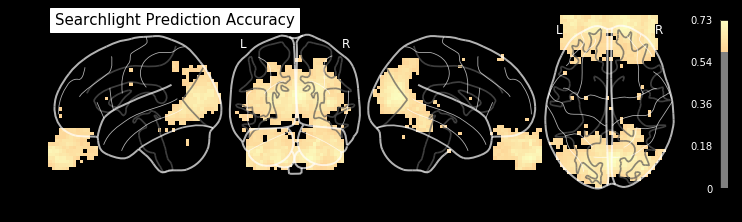

In [39]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy')

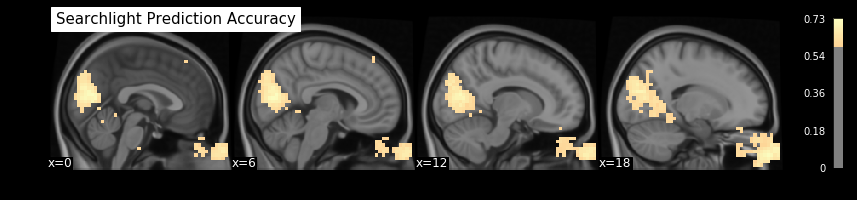

In [40]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

As expected and already seen before, the hotspots with high prediction accuracy are around the primary visual cortex (in the back of the head) and around the eyes.

# PyMVPA

[PyMVPA](http://www.pymvpa.org/) is a Python package intended to ease statistical learning analyses of large datasets. It offers an extensible framework with a high-level interface to a broad range of algorithms for classification, regression, feature selection, data import and export.

The power in PyMVPA lies in it's flexibility with classifier. PyMVPA is able to use many classifiers from LIBSVM and scikit-learn, and the overall list that are at your hands is impressive. The following are only some of the classifiers that you can chose from:

- Bayesian Linear Regression (BLR)
- Elastic-Net (ENET) regression classifier
- Gaussian Discriminant Analyses (LDA and QDA)
- Gaussian Naive Bayes Classifier (GNB)
- Gaussian Process Regression (GPR)
- GLM-Net (GLMNET) regression and classifier
- k-Nearest-Neighbour classifier (kNN)
- Least angle regression (LARS)
- Penalized logistic regression classifier
- Similarity functions for prototype-based projection
- Sparse Multinomial Logistic Regression classifier (SMLR)
- SVM and SVR machines

**Note:** The content of this notebook is taken and adapted from the [PyMVPA](http://www.pymvpa.org/) homepage and serves an illustrative purpose. For more information and better understanding, go directly to [PyMVPA](http://www.pymvpa.org/).

Having said so, let's take a look at PyMVPA's **Searchlight** example.

## Preparation

As searchlight analyses are usually quite expensive in terms of computational resources, we are going to enable some progress output to entertain us while we are waiting.

In [41]:
from mvpa2.suite import *

# enable debug output for searchlight call
if __debug__:
    debug.active += ["SLC"]

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/datasets/sources/skl_data.py:32: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argnames, varargs, varkw, defaults = inspect.getargspec(fx)
<string>:60: DeprecationWarning: invalid escape sequence \#
<string>:59: DeprecationWarning: invalid escape sequence \#
<string>:59: DeprecationWarning: invalid escape sequence \#
<string>:65: DeprecationWarning: invalid escape sequence \

PyMVPA uses dataset objects that contain all necessary information for the searchlight analysis in one object. So let's construct such a dataset object. The only thing we need are: our data, the labels, the chanks and a mask that specifies the region in which we want to run the searchlight.

In [42]:
ds = fmri_dataset(samples=func,
                  targets=labels,
                  chunks=chunks,
                  mask=get_mask('both'))

 * Please note: warnings are printed only once, but underlying problem might occur many times *


Now, as we saw before. Running the searchlight on each and ever voxel might be very computation intensive. Luckily PyMVPA's searchlight allows some shortcuts. For example, we can run the searchlight only on every X voxel. If we do so, we will have many wholes/missing values for all the voxels that we didn't do the cross-validation for.

One solution to counter act this is by filling out those empty voxels with the average accuracy of all surrounding searchlight spheres. In other words, the value stored in each voxel is the average prediction accuracy of all the spheres that include this voxel in their computation.

It will make more sense later on. But first, let's specify the function that does this step:

In [43]:
def fill_in_scattered_results(sl, dataset, roi_ids, results):
    """Function to aggregate results - This requires the searchlight
    conditional attribute 'roi_feature_ids' to be enabled"""
    import numpy as np
    from mvpa2.datasets import Dataset
    resmap = None
    for resblock in results:
        for res in resblock:
            if resmap is None:
                # prepare the result container
                resmap = np.zeros((len(res), dataset.nfeatures),
                                  dtype=res.samples.dtype)
                observ_counter = np.zeros(dataset.nfeatures, dtype=int)
            # project the result onto all features -- love broadcasting!
            resmap[:, res.a.roi_feature_ids] += res.samples
            # increment observation counter for all relevant features
            observ_counter[res.a.roi_feature_ids] += 1
    # when all results have been added up average them according to the number
    # of observations
    observ_mask = observ_counter > 0
    resmap[:, observ_mask] /= observ_counter[observ_mask]
    result_ds = Dataset(resmap,
                        fa={'observations': observ_counter})
    if 'mapper' in dataset.a:
        import copy
        result_ds.a['mapper'] = copy.copy(dataset.a.mapper)
    return result_ds

## Setting up the Searchlight Object

Now we're good to go! So, as before, we need to specify a cross-validation scheme. Let's use again a Leave-one-out cross-validation, i.e. a N-Fold approach.

In [44]:
# Specify cross-validation scheme
cv_scheme = NFoldPartitioner(cvtype=1)

As a next step we need to specify the classifier we want to use. Here is where PyMVPA shines. There are so many... But for this example, let's focus again on the linear support vector machine classifier:

In [45]:
clf = LinearCSVMC()

Let's put this all into a cross-validation object.

In [46]:
cv = CrossValidation(clf,
                     cv_scheme,
                     errorfx=mean_match_accuracy,
                     enable_ca=['stats'])

And as a final step, we need again to specify the size of the sphere and also the step-size we want to use, i.e. the distance between spheres.

In [47]:
# Radius of the searchlight sphere
sphere_radius = 2   # in voxels

In [48]:
# Step size / voxel distance between spheres
nth_element = 50

This `nth_element` parameter is great as it reduces the computation time of the searchlight. And as mentioned above, using the `fill_in_scattered_results()` function allows us to fill up all the missing values that we didn't compute. Additionally, this serves as some kind of data smoothing, which also increases the signal-to-noise ratio (SNR).

Now we're ready and can put this all into the searchlight classifier object:

In [49]:
sl = sphere_searchlight(cv,
                        radius=sphere_radius,
                        center_ids=range(0,
                                         ds.shape[1],
                                         nth_element),
                        space='voxel_indices',
                        results_fx=fill_in_scattered_results,
                        postproc=mean_sample(),
                        enable_ca=['calling_time', 'roi_feature_ids'])
sl.nproc = 1  # Specifies the number of parallel jobs

And we're good to go. Let's train the classifier!

In [50]:
sl_map = sl(ds)

[SLC] DBG:                              Starting computing block for 748 elements
[SLC] DBG:                              +0:00:00 _______[0%]_______ -0:01:14  ROI 51 (2/748), 18 features

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/misc/attrmap.py:153: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if not np.issubdtype(attr.dtype, str) and not self.mapnumeric:
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/clfs/libsvmc/svm.py:215: FutureWarning: Conversion of the second argument of issubdtype from `'c'` to `bytes` is deprecated. In future, it will be treated as `np.bytes_ == np.dtype('c').type`.
  if ( np.issubdtype(self.ca.trained_targets.dtype, 'c') or
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/clfs/libsvmc/svm.py:216: FutureWarning: Conversion of the second argument of issubdtype from `'U'` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype('U').type`.
  np.issubdtype(self.ca.trained_targets.dtype, 'U') ):


[SLC] DBG:                              +0:01:15 ======[100%]====== 0:00:00  ROI 37351 (748/748), 22 features 


So, what does the result look like? Let's put it back into an MRI image and plot it on the glass brain.

In [51]:
# Access the searchlight output data and put it into an MRI image
sl_data = ds.mapper.reverse(sl_map.S)[0, ...]

from nilearn.image import new_img_like
sl_img = new_img_like(func, sl_data)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


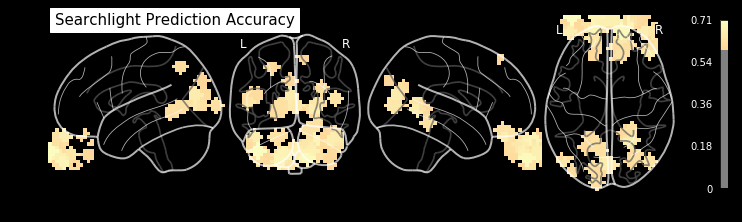

In [52]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(sl_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.60, cmap='magma', title='Searchlight Prediction Accuracy')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


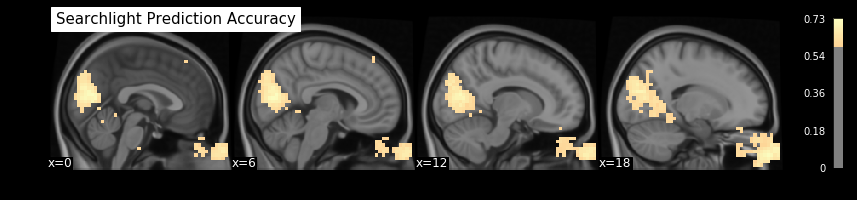

In [53]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

**Note about parallel execution:** The PyMVPA version in this docker container doesn't run in parallel, i.e. it runs only on one core. If you want to have parallel execution, you need create a Python 2.7 environment and install `PyMVPA` and `pprocess`. Once this is done, you can use the paramter `sl.nproc` to define how many parallel jobs you want to use.

# Gender Differences?

As a fun additional exercise, can we predict the gender of a participant, solely based on the resting-state fMRI data?

We can do this, as we also know the gender of our 48 participants. So, to do the analysis with gender as prediction label, we just have to change the labels file and can keep the rest as was.

In [54]:
# Gender of the 48 participants
gender = ['M', 'F', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F',
          'M', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'M', 'F',
          'F', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'F',
          'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'M']

labels = np.ravel([[g] * 8 for g in gender])

Now we can run the same code again as above. So let's first run a simple MVPA.

In [55]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=25)

# Performe the cross validation (takes time to compute)
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 80.21 percent

Accuracy per fold:
[0.921875 1.       0.71875  0.875    0.578125 0.71875 ]


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.8s finished


Also prediction accuracy above 80%??? That's really cool, even though it's very difficult to explain why this is the case. Well, let's see if this is significant. There's surely something off...

In [56]:
# Let's chose again the linear SVC
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Import the permuation function
from sklearn.model_selection import permutation_test_score

# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=25,
                                        n_jobs=-1,
                                        verbose=1)

print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

Prediction accuracy: 77.60
p-value: 0.0385


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.0s finished


... ok... so it's significant... Why??? What is driving this difference?

Let's run the **SpaceNet** classifier to see where the weights are that mostly drive this classification.

In [57]:
# Create two masks that specify the training and the test set 
mask_test = chunks == 5
mask_train = np.invert(mask_test)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
from nilearn.image import index_img
X_train = index_img(func, mask_train)
y_train = labels[mask_train]

X_test = index_img(func, mask_test)
y_test = labels[mask_test]

from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=get_mask('both'),
                             max_iter=10,
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = decoder.predict(X_test)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/decoding/space_net.py:835: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f6d33cfa9d8>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([1, ..., 1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 44, ..., 319]), array([  0, ..., 100]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=15.268555470880802)


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/decoding/objective_functions.py:209: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gradient[slice_all] = np.diff(img, axis=d)


______________________________________________________path_scores - 4.3s, 0.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f6d33cfa9d8>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([1, ..., 1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 319]), array([ 44,  45,  46,  47,  56,  57,  58,  59,  60,  61,  62,  63,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94, 101, 102, 103, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 144, 145, 146, 147, 148, 149, 150, 151, 160, 161]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.6s finished


In [58]:
# Retrun average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)


TV-l1  classification accuracy : 73.4375%


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


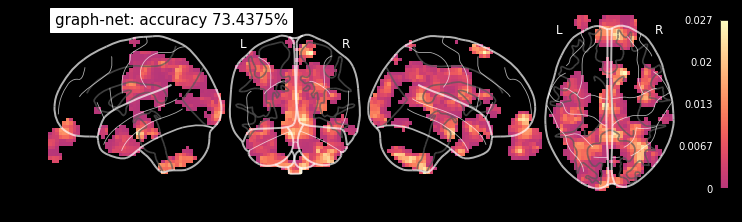

In [59]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

We're at a loss... It seems that this effect is robust and present. But it also seems that the weights are a bit everywhere in the brain.

So let's run a **Searchlight** classifier to see what the local prediction accuracy is for each region.

In [60]:
from nilearn.decoding import SearchLight

# Specify the mask in which the searchlight should be performed
mask = get_mask('both')

# Specify the classifier to use
# Let's use again a GaussainNB classifier to reduce computation time
clf = GaussianNB()

# Specify the radius of the searchlight sphere  that will scan the volume
# (the bigger the longer the computation)
sphere_radius = 8  # in mm

# Create searchlight object
sl = SearchLight(mask,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=-1,
                 verbose=1)

# Run the searchlight algorithm
sl.fit(nb.load(func), labels, groups=chunks)

Job #1, processed 0/4675 voxels (0.00%, 88 seconds remaining)
Job #1, processed 10/4675 voxels (0.21%, 40 seconds remaining)
Job #2, processed 0/4675 voxels (0.00%, 89 seconds remaining)
Job #1, processed 20/4675 voxels (0.43%, 34 seconds remaining)
Job #2, processed 10/4675 voxels (0.21%, 47 seconds remaining)
Job #1, processed 30/4675 voxels (0.64%, 34 seconds remaining)
Job #3, processed 0/4675 voxels (0.00%, 106 seconds remaining)
Job #2, processed 20/4675 voxels (0.43%, 39 seconds remaining)
Job #1, processed 40/4675 voxels (0.86%, 33 seconds remaining)
Job #4, processed 0/4675 voxels (0.00%, 86 seconds remaining)
Job #3, processed 10/4675 voxels (0.21%, 56 seconds remaining)
Job #1, processed 50/4675 voxels (1.07%, 33 seconds remaining)
Job #2, processed 30/4675 voxels (0.64%, 42 seconds remaining)
Job #4, processed 10/4675 voxels (0.21%, 41 seconds remaining)
Job #3, processed 20/4675 voxels (0.43%, 45 seconds remaining)
Job #5, processed 0/4675 voxels (0.00%, 144 seconds remain

Job #3, processed 170/4675 voxels (3.64%, 58 seconds remaining)
Job #8, processed 120/4674 voxels (2.57%, 62 seconds remaining)
Job #2, processed 190/4675 voxels (4.06%, 55 seconds remaining)
Job #6, processed 140/4675 voxels (2.99%, 61 seconds remaining)
Job #4, processed 170/4675 voxels (3.64%, 57 seconds remaining)
Job #7, processed 140/4674 voxels (3.00%, 58 seconds remaining)
Job #1, processed 210/4675 voxels (4.49%, 52 seconds remaining)
Job #5, processed 160/4675 voxels (3.42%, 59 seconds remaining)
Job #3, processed 180/4675 voxels (3.85%, 58 seconds remaining)
Job #8, processed 130/4674 voxels (2.78%, 61 seconds remaining)
Job #6, processed 150/4675 voxels (3.21%, 61 seconds remaining)
Job #2, processed 200/4675 voxels (4.28%, 55 seconds remaining)
Job #4, processed 180/4675 voxels (3.85%, 56 seconds remaining)
Job #1, processed 220/4675 voxels (4.71%, 52 seconds remaining)
Job #7, processed 150/4674 voxels (3.21%, 59 seconds remaining)
Job #5, processed 170/4675 voxels (3.64%

Job #6, processed 300/4675 voxels (6.42%, 58 seconds remaining)
Job #3, processed 340/4675 voxels (7.27%, 55 seconds remaining)
Job #7, processed 300/4674 voxels (6.42%, 56 seconds remaining)
Job #2, processed 340/4675 voxels (7.27%, 56 seconds remaining)
Job #8, processed 290/4674 voxels (6.20%, 57 seconds remaining)
Job #4, processed 330/4675 voxels (7.06%, 56 seconds remaining)
Job #1, processed 370/4675 voxels (7.91%, 53 seconds remaining)
Job #5, processed 320/4675 voxels (6.84%, 57 seconds remaining)
Job #3, processed 350/4675 voxels (7.49%, 54 seconds remaining)
Job #6, processed 310/4675 voxels (6.63%, 57 seconds remaining)
Job #7, processed 310/4674 voxels (6.63%, 56 seconds remaining)
Job #2, processed 350/4675 voxels (7.49%, 56 seconds remaining)
Job #8, processed 300/4674 voxels (6.42%, 57 seconds remaining)
Job #4, processed 340/4675 voxels (7.27%, 56 seconds remaining)
Job #1, processed 380/4675 voxels (8.13%, 53 seconds remaining)
Job #5, processed 330/4675 voxels (7.06%

Job #8, processed 450/4674 voxels (9.63%, 54 seconds remaining)
Job #3, processed 500/4675 voxels (10.70%, 53 seconds remaining)
Job #7, processed 460/4674 voxels (9.84%, 55 seconds remaining)
Job #6, processed 460/4675 voxels (9.84%, 56 seconds remaining)
Job #4, processed 490/4675 voxels (10.48%, 54 seconds remaining)
Job #8, processed 460/4674 voxels (9.84%, 54 seconds remaining)
Job #2, processed 500/4675 voxels (10.70%, 55 seconds remaining)
Job #1, processed 540/4675 voxels (11.55%, 51 seconds remaining)
Job #3, processed 510/4675 voxels (10.91%, 53 seconds remaining)
Job #5, processed 470/4675 voxels (10.05%, 56 seconds remaining)
Job #7, processed 470/4674 voxels (10.06%, 54 seconds remaining)
Job #6, processed 470/4675 voxels (10.05%, 55 seconds remaining)
Job #1, processed 550/4675 voxels (11.76%, 51 seconds remaining)
Job #8, processed 470/4674 voxels (10.06%, 54 seconds remaining)
Job #4, processed 500/4675 voxels (10.70%, 54 seconds remaining)
Job #5, processed 480/4675 vo

Job #7, processed 620/4674 voxels (13.26%, 52 seconds remaining)
Job #3, processed 660/4675 voxels (14.12%, 51 seconds remaining)
Job #2, processed 650/4675 voxels (13.90%, 53 seconds remaining)
Job #6, processed 620/4675 voxels (13.26%, 53 seconds remaining)
Job #5, processed 630/4675 voxels (13.48%, 53 seconds remaining)
Job #4, processed 640/4675 voxels (13.69%, 53 seconds remaining)
Job #7, processed 630/4674 voxels (13.48%, 52 seconds remaining)
Job #8, processed 610/4674 voxels (13.05%, 53 seconds remaining)
Job #3, processed 670/4675 voxels (14.33%, 51 seconds remaining)
Job #1, processed 710/4675 voxels (15.19%, 49 seconds remaining)
Job #2, processed 660/4675 voxels (14.12%, 52 seconds remaining)
Job #6, processed 630/4675 voxels (13.48%, 53 seconds remaining)
Job #5, processed 640/4675 voxels (13.69%, 53 seconds remaining)
Job #4, processed 650/4675 voxels (13.90%, 53 seconds remaining)
Job #2, processed 670/4675 voxels (14.33%, 52 seconds remaining)
Job #3, processed 680/467

Job #6, processed 780/4675 voxels (16.68%, 51 seconds remaining)
Job #4, processed 780/4675 voxels (16.68%, 52 seconds remaining)
Job #2, processed 810/4675 voxels (17.33%, 51 seconds remaining)
Job #3, processed 820/4675 voxels (17.54%, 50 seconds remaining)
Job #1, processed 870/4675 voxels (18.61%, 47 seconds remaining)
Job #8, processed 770/4674 voxels (16.47%, 51 seconds remaining)
Job #7, processed 790/4674 voxels (16.90%, 50 seconds remaining)
Job #5, processed 790/4675 voxels (16.90%, 51 seconds remaining)
Job #6, processed 790/4675 voxels (16.90%, 51 seconds remaining)
Job #4, processed 790/4675 voxels (16.90%, 52 seconds remaining)
Job #2, processed 820/4675 voxels (17.54%, 51 seconds remaining)
Job #3, processed 830/4675 voxels (17.75%, 50 seconds remaining)
Job #8, processed 780/4674 voxels (16.69%, 51 seconds remaining)
Job #7, processed 800/4674 voxels (17.12%, 50 seconds remaining)
Job #1, processed 880/4675 voxels (18.82%, 47 seconds remaining)
Job #5, processed 800/467

Job #3, processed 960/4675 voxels (20.53%, 49 seconds remaining)
Job #5, processed 940/4675 voxels (20.11%, 49 seconds remaining)
Job #4, processed 950/4675 voxels (20.32%, 49 seconds remaining)
Job #8, processed 930/4674 voxels (19.90%, 49 seconds remaining)
Job #7, processed 940/4674 voxels (20.11%, 49 seconds remaining)
Job #2, processed 960/4675 voxels (20.53%, 50 seconds remaining)
Job #1, processed 1040/4675 voxels (22.25%, 45 seconds remaining)
Job #6, processed 950/4675 voxels (20.32%, 49 seconds remaining)
Job #3, processed 970/4675 voxels (20.75%, 49 seconds remaining)
Job #4, processed 960/4675 voxels (20.53%, 49 seconds remaining)
Job #5, processed 950/4675 voxels (20.32%, 49 seconds remaining)
Job #8, processed 940/4674 voxels (20.11%, 49 seconds remaining)
Job #2, processed 970/4675 voxels (20.75%, 49 seconds remaining)
Job #1, processed 1050/4675 voxels (22.46%, 45 seconds remaining)
Job #6, processed 960/4675 voxels (20.53%, 49 seconds remaining)
Job #3, processed 980/4

Job #3, processed 1120/4675 voxels (23.96%, 47 seconds remaining)
Job #8, processed 1080/4674 voxels (23.11%, 47 seconds remaining)
Job #2, processed 1120/4675 voxels (23.96%, 47 seconds remaining)
Job #5, processed 1090/4675 voxels (23.32%, 48 seconds remaining)
Job #4, processed 1110/4675 voxels (23.74%, 47 seconds remaining)
Job #1, processed 1190/4675 voxels (25.45%, 44 seconds remaining)
Job #3, processed 1130/4675 voxels (24.17%, 47 seconds remaining)
Job #6, processed 1110/4675 voxels (23.74%, 47 seconds remaining)
Job #7, processed 1100/4674 voxels (23.53%, 47 seconds remaining)
Job #8, processed 1090/4674 voxels (23.32%, 47 seconds remaining)
Job #5, processed 1100/4675 voxels (23.53%, 48 seconds remaining)
Job #2, processed 1130/4675 voxels (24.17%, 47 seconds remaining)
Job #4, processed 1120/4675 voxels (23.96%, 47 seconds remaining)
Job #3, processed 1140/4675 voxels (24.39%, 47 seconds remaining)
Job #6, processed 1120/4675 voxels (23.96%, 47 seconds remaining)
Job #1, pr

Job #6, processed 1260/4675 voxels (26.95%, 45 seconds remaining)
Job #5, processed 1250/4675 voxels (26.74%, 45 seconds remaining)
Job #4, processed 1270/4675 voxels (27.17%, 45 seconds remaining)
Job #7, processed 1240/4674 voxels (26.53%, 45 seconds remaining)
Job #3, processed 1290/4675 voxels (27.59%, 44 seconds remaining)
Job #1, processed 1350/4675 voxels (28.88%, 42 seconds remaining)
Job #2, processed 1270/4675 voxels (27.17%, 45 seconds remaining)
Job #8, processed 1240/4674 voxels (26.53%, 45 seconds remaining)
Job #5, processed 1260/4675 voxels (26.95%, 45 seconds remaining)
Job #6, processed 1270/4675 voxels (27.17%, 44 seconds remaining)
Job #4, processed 1280/4675 voxels (27.38%, 45 seconds remaining)
Job #1, processed 1360/4675 voxels (29.09%, 42 seconds remaining)
Job #3, processed 1300/4675 voxels (27.81%, 44 seconds remaining)
Job #7, processed 1250/4674 voxels (26.74%, 45 seconds remaining)
Job #2, processed 1280/4675 voxels (27.38%, 45 seconds remaining)
Job #5, pr

Job #8, processed 1390/4674 voxels (29.74%, 44 seconds remaining)
Job #4, processed 1430/4675 voxels (30.59%, 43 seconds remaining)
Job #7, processed 1390/4674 voxels (29.74%, 44 seconds remaining)
Job #6, processed 1420/4675 voxels (30.37%, 43 seconds remaining)
Job #2, processed 1420/4675 voxels (30.37%, 44 seconds remaining)
Job #3, processed 1450/4675 voxels (31.02%, 42 seconds remaining)
Job #5, processed 1410/4675 voxels (30.16%, 44 seconds remaining)
Job #1, processed 1510/4675 voxels (32.30%, 40 seconds remaining)
Job #8, processed 1400/4674 voxels (29.95%, 43 seconds remaining)
Job #4, processed 1440/4675 voxels (30.80%, 43 seconds remaining)
Job #5, processed 1420/4675 voxels (30.37%, 43 seconds remaining)
Job #6, processed 1430/4675 voxels (30.59%, 43 seconds remaining)
Job #2, processed 1430/4675 voxels (30.59%, 44 seconds remaining)
Job #3, processed 1460/4675 voxels (31.23%, 42 seconds remaining)
Job #7, processed 1400/4674 voxels (29.95%, 44 seconds remaining)
Job #1, pr

Job #2, processed 1570/4675 voxels (33.58%, 42 seconds remaining)
Job #7, processed 1540/4674 voxels (32.95%, 42 seconds remaining)
Job #1, processed 1670/4675 voxels (35.72%, 38 seconds remaining)
Job #4, processed 1580/4675 voxels (33.80%, 41 seconds remaining)
Job #3, processed 1610/4675 voxels (34.44%, 40 seconds remaining)
Job #8, processed 1550/4674 voxels (33.16%, 41 seconds remaining)
Job #6, processed 1570/4675 voxels (33.58%, 41 seconds remaining)
Job #5, processed 1580/4675 voxels (33.80%, 41 seconds remaining)
Job #2, processed 1580/4675 voxels (33.80%, 42 seconds remaining)
Job #7, processed 1550/4674 voxels (33.16%, 42 seconds remaining)
Job #1, processed 1680/4675 voxels (35.94%, 38 seconds remaining)
Job #4, processed 1590/4675 voxels (34.01%, 41 seconds remaining)
Job #3, processed 1620/4675 voxels (34.65%, 40 seconds remaining)
Job #6, processed 1580/4675 voxels (33.80%, 41 seconds remaining)
Job #8, processed 1560/4674 voxels (33.38%, 41 seconds remaining)
Job #5, pr

Job #2, processed 1730/4675 voxels (37.01%, 39 seconds remaining)
Job #7, processed 1690/4674 voxels (36.16%, 40 seconds remaining)
Job #5, processed 1730/4675 voxels (37.01%, 39 seconds remaining)
Job #4, processed 1740/4675 voxels (37.22%, 39 seconds remaining)
Job #1, processed 1830/4675 voxels (39.14%, 36 seconds remaining)
Job #6, processed 1730/4675 voxels (37.01%, 39 seconds remaining)
Job #8, processed 1710/4674 voxels (36.59%, 39 seconds remaining)
Job #2, processed 1740/4675 voxels (37.22%, 39 seconds remaining)
Job #3, processed 1760/4675 voxels (37.65%, 38 seconds remaining)
Job #7, processed 1700/4674 voxels (36.37%, 40 seconds remaining)
Job #5, processed 1740/4675 voxels (37.22%, 39 seconds remaining)
Job #4, processed 1750/4675 voxels (37.43%, 39 seconds remaining)
Job #1, processed 1840/4675 voxels (39.36%, 36 seconds remaining)
Job #8, processed 1720/4674 voxels (36.80%, 39 seconds remaining)
Job #2, processed 1750/4675 voxels (37.43%, 39 seconds remaining)
Job #3, pr

Job #6, processed 1870/4675 voxels (40.00%, 37 seconds remaining)
Job #8, processed 1860/4674 voxels (39.79%, 37 seconds remaining)
Job #5, processed 1890/4675 voxels (40.43%, 36 seconds remaining)
Job #1, processed 1990/4675 voxels (42.57%, 34 seconds remaining)
Job #7, processed 1850/4674 voxels (39.58%, 37 seconds remaining)
Job #2, processed 1890/4675 voxels (40.43%, 37 seconds remaining)
Job #3, processed 1920/4675 voxels (41.07%, 36 seconds remaining)
Job #4, processed 1900/4675 voxels (40.64%, 36 seconds remaining)
Job #6, processed 1880/4675 voxels (40.21%, 37 seconds remaining)
Job #5, processed 1900/4675 voxels (40.64%, 36 seconds remaining)
Job #8, processed 1870/4674 voxels (40.01%, 37 seconds remaining)
Job #7, processed 1860/4674 voxels (39.79%, 37 seconds remaining)
Job #1, processed 2000/4675 voxels (42.78%, 34 seconds remaining)
Job #3, processed 1930/4675 voxels (41.28%, 36 seconds remaining)
Job #4, processed 1910/4675 voxels (40.86%, 36 seconds remaining)
Job #2, pr

Job #2, processed 2040/4675 voxels (43.64%, 35 seconds remaining)
Job #7, processed 2010/4674 voxels (43.00%, 35 seconds remaining)
Job #4, processed 2050/4675 voxels (43.85%, 34 seconds remaining)
Job #3, processed 2070/4675 voxels (44.28%, 34 seconds remaining)
Job #6, processed 2030/4675 voxels (43.42%, 35 seconds remaining)
Job #5, processed 2050/4675 voxels (43.85%, 34 seconds remaining)
Job #8, processed 2020/4674 voxels (43.22%, 35 seconds remaining)
Job #1, processed 2150/4675 voxels (45.99%, 32 seconds remaining)
Job #2, processed 2050/4675 voxels (43.85%, 35 seconds remaining)
Job #7, processed 2020/4674 voxels (43.22%, 35 seconds remaining)
Job #4, processed 2060/4675 voxels (44.06%, 34 seconds remaining)
Job #3, processed 2080/4675 voxels (44.49%, 34 seconds remaining)
Job #6, processed 2040/4675 voxels (43.64%, 35 seconds remaining)
Job #5, processed 2060/4675 voxels (44.06%, 34 seconds remaining)
Job #8, processed 2030/4674 voxels (43.43%, 35 seconds remaining)
Job #2, pr

Job #1, processed 2290/4675 voxels (48.98%, 30 seconds remaining)
Job #4, processed 2210/4675 voxels (47.27%, 32 seconds remaining)
Job #2, processed 2200/4675 voxels (47.06%, 33 seconds remaining)
Job #3, processed 2230/4675 voxels (47.70%, 32 seconds remaining)
Job #6, processed 2190/4675 voxels (46.84%, 32 seconds remaining)
Job #5, processed 2200/4675 voxels (47.06%, 32 seconds remaining)
Job #7, processed 2170/4674 voxels (46.43%, 33 seconds remaining)
Job #8, processed 2180/4674 voxels (46.64%, 32 seconds remaining)
Job #1, processed 2300/4675 voxels (49.20%, 30 seconds remaining)
Job #4, processed 2220/4675 voxels (47.49%, 32 seconds remaining)
Job #2, processed 2210/4675 voxels (47.27%, 32 seconds remaining)
Job #3, processed 2240/4675 voxels (47.91%, 31 seconds remaining)
Job #6, processed 2200/4675 voxels (47.06%, 32 seconds remaining)
Job #5, processed 2210/4675 voxels (47.27%, 32 seconds remaining)
Job #7, processed 2180/4674 voxels (46.64%, 33 seconds remaining)
Job #8, pr

Job #2, processed 2350/4675 voxels (50.27%, 30 seconds remaining)
Job #6, processed 2350/4675 voxels (50.27%, 30 seconds remaining)
Job #7, processed 2320/4674 voxels (49.64%, 31 seconds remaining)
Job #3, processed 2380/4675 voxels (50.91%, 30 seconds remaining)
Job #8, processed 2330/4674 voxels (49.85%, 30 seconds remaining)
Job #5, processed 2360/4675 voxels (50.48%, 30 seconds remaining)
Job #1, processed 2450/4675 voxels (52.41%, 28 seconds remaining)
Job #4, processed 2380/4675 voxels (50.91%, 30 seconds remaining)
Job #2, processed 2360/4675 voxels (50.48%, 30 seconds remaining)
Job #6, processed 2360/4675 voxels (50.48%, 30 seconds remaining)
Job #7, processed 2330/4674 voxels (49.85%, 31 seconds remaining)
Job #3, processed 2390/4675 voxels (51.12%, 30 seconds remaining)
Job #5, processed 2370/4675 voxels (50.70%, 30 seconds remaining)
Job #8, processed 2340/4674 voxels (50.06%, 30 seconds remaining)
Job #1, processed 2460/4675 voxels (52.62%, 28 seconds remaining)
Job #4, pr

Job #1, processed 2600/4675 voxels (55.61%, 26 seconds remaining)
Job #4, processed 2530/4675 voxels (54.12%, 28 seconds remaining)
Job #3, processed 2530/4675 voxels (54.12%, 28 seconds remaining)
Job #2, processed 2510/4675 voxels (53.69%, 28 seconds remaining)
Job #7, processed 2480/4674 voxels (53.06%, 29 seconds remaining)
Job #8, processed 2490/4674 voxels (53.27%, 28 seconds remaining)
Job #5, processed 2520/4675 voxels (53.90%, 28 seconds remaining)
Job #6, processed 2510/4675 voxels (53.69%, 28 seconds remaining)
Job #4, processed 2540/4675 voxels (54.33%, 27 seconds remaining)
Job #1, processed 2610/4675 voxels (55.83%, 26 seconds remaining)
Job #3, processed 2540/4675 voxels (54.33%, 28 seconds remaining)
Job #7, processed 2490/4674 voxels (53.27%, 28 seconds remaining)
Job #8, processed 2500/4674 voxels (53.49%, 28 seconds remaining)
Job #2, processed 2520/4675 voxels (53.90%, 28 seconds remaining)
Job #5, processed 2530/4675 voxels (54.12%, 28 seconds remaining)
Job #6, pr

Job #8, processed 2640/4674 voxels (56.48%, 26 seconds remaining)
Job #3, processed 2680/4675 voxels (57.33%, 26 seconds remaining)
Job #5, processed 2670/4675 voxels (57.11%, 26 seconds remaining)
Job #1, processed 2760/4675 voxels (59.04%, 24 seconds remaining)
Job #2, processed 2670/4675 voxels (57.11%, 26 seconds remaining)
Job #6, processed 2660/4675 voxels (56.90%, 26 seconds remaining)
Job #7, processed 2640/4674 voxels (56.48%, 26 seconds remaining)
Job #4, processed 2700/4675 voxels (57.75%, 25 seconds remaining)
Job #8, processed 2650/4674 voxels (56.70%, 26 seconds remaining)
Job #5, processed 2680/4675 voxels (57.33%, 26 seconds remaining)
Job #3, processed 2690/4675 voxels (57.54%, 26 seconds remaining)
Job #1, processed 2770/4675 voxels (59.25%, 24 seconds remaining)
Job #2, processed 2680/4675 voxels (57.33%, 26 seconds remaining)
Job #7, processed 2650/4674 voxels (56.70%, 26 seconds remaining)
Job #4, processed 2710/4675 voxels (57.97%, 25 seconds remaining)
Job #6, pr

Job #8, processed 2800/4674 voxels (59.91%, 24 seconds remaining)
Job #3, processed 2840/4675 voxels (60.75%, 24 seconds remaining)
Job #5, processed 2820/4675 voxels (60.32%, 24 seconds remaining)
Job #1, processed 2920/4675 voxels (62.46%, 22 seconds remaining)
Job #7, processed 2800/4674 voxels (59.91%, 24 seconds remaining)
Job #6, processed 2810/4675 voxels (60.11%, 24 seconds remaining)
Job #2, processed 2820/4675 voxels (60.32%, 24 seconds remaining)
Job #4, processed 2860/4675 voxels (61.18%, 23 seconds remaining)
Job #3, processed 2850/4675 voxels (60.96%, 23 seconds remaining)
Job #5, processed 2830/4675 voxels (60.53%, 24 seconds remaining)
Job #1, processed 2930/4675 voxels (62.67%, 22 seconds remaining)
Job #7, processed 2810/4674 voxels (60.12%, 24 seconds remaining)
Job #8, processed 2810/4674 voxels (60.12%, 24 seconds remaining)
Job #6, processed 2820/4675 voxels (60.32%, 24 seconds remaining)
Job #2, processed 2830/4675 voxels (60.53%, 24 seconds remaining)
Job #4, pr

Job #5, processed 2980/4675 voxels (63.74%, 22 seconds remaining)
Job #2, processed 2970/4675 voxels (63.53%, 22 seconds remaining)
Job #1, processed 3080/4675 voxels (65.88%, 20 seconds remaining)
Job #3, processed 2990/4675 voxels (63.96%, 22 seconds remaining)
Job #6, processed 2960/4675 voxels (63.32%, 22 seconds remaining)
Job #8, processed 2960/4674 voxels (63.33%, 22 seconds remaining)
Job #7, processed 2960/4674 voxels (63.33%, 22 seconds remaining)
Job #4, processed 3020/4675 voxels (64.60%, 21 seconds remaining)
Job #5, processed 2990/4675 voxels (63.96%, 22 seconds remaining)
Job #2, processed 2980/4675 voxels (63.74%, 22 seconds remaining)
Job #3, processed 3000/4675 voxels (64.17%, 21 seconds remaining)
Job #1, processed 3090/4675 voxels (66.10%, 20 seconds remaining)
Job #6, processed 2970/4675 voxels (63.53%, 22 seconds remaining)
Job #4, processed 3030/4675 voxels (64.81%, 21 seconds remaining)
Job #8, processed 2970/4674 voxels (63.54%, 22 seconds remaining)
Job #5, pr

Job #6, processed 3110/4675 voxels (66.52%, 20 seconds remaining)
Job #7, processed 3110/4674 voxels (66.54%, 20 seconds remaining)
Job #1, processed 3230/4675 voxels (69.09%, 18 seconds remaining)
Job #5, processed 3140/4675 voxels (67.17%, 20 seconds remaining)
Job #2, processed 3130/4675 voxels (66.95%, 20 seconds remaining)
Job #3, processed 3150/4675 voxels (67.38%, 19 seconds remaining)
Job #8, processed 3120/4674 voxels (66.75%, 20 seconds remaining)
Job #4, processed 3180/4675 voxels (68.02%, 19 seconds remaining)
Job #6, processed 3120/4675 voxels (66.74%, 20 seconds remaining)
Job #7, processed 3120/4674 voxels (66.75%, 20 seconds remaining)
Job #2, processed 3140/4675 voxels (67.17%, 20 seconds remaining)
Job #5, processed 3150/4675 voxels (67.38%, 19 seconds remaining)
Job #1, processed 3240/4675 voxels (69.30%, 18 seconds remaining)
Job #3, processed 3160/4675 voxels (67.59%, 19 seconds remaining)
Job #8, processed 3130/4674 voxels (66.97%, 20 seconds remaining)
Job #4, pr

Job #7, processed 3270/4674 voxels (69.96%, 18 seconds remaining)
Job #2, processed 3280/4675 voxels (70.16%, 18 seconds remaining)
Job #4, processed 3320/4675 voxels (71.02%, 17 seconds remaining)
Job #3, processed 3310/4675 voxels (70.80%, 17 seconds remaining)
Job #1, processed 3390/4675 voxels (72.51%, 16 seconds remaining)
Job #6, processed 3270/4675 voxels (69.95%, 18 seconds remaining)
Job #7, processed 3280/4674 voxels (70.18%, 18 seconds remaining)
Job #8, processed 3280/4674 voxels (70.18%, 18 seconds remaining)
Job #5, processed 3300/4675 voxels (70.59%, 17 seconds remaining)
Job #2, processed 3290/4675 voxels (70.37%, 18 seconds remaining)
Job #4, processed 3330/4675 voxels (71.23%, 17 seconds remaining)
Job #3, processed 3320/4675 voxels (71.02%, 17 seconds remaining)
Job #1, processed 3400/4675 voxels (72.73%, 16 seconds remaining)
Job #6, processed 3280/4675 voxels (70.16%, 18 seconds remaining)
Job #7, processed 3290/4674 voxels (70.39%, 18 seconds remaining)
Job #8, pr

Job #2, processed 3430/4675 voxels (73.37%, 16 seconds remaining)
Job #4, processed 3480/4675 voxels (74.44%, 15 seconds remaining)
Job #1, processed 3540/4675 voxels (75.72%, 14 seconds remaining)
Job #8, processed 3430/4674 voxels (73.38%, 16 seconds remaining)
Job #3, processed 3470/4675 voxels (74.22%, 15 seconds remaining)
Job #7, processed 3430/4674 voxels (73.38%, 16 seconds remaining)
Job #6, processed 3430/4675 voxels (73.37%, 16 seconds remaining)
Job #5, processed 3460/4675 voxels (74.01%, 15 seconds remaining)
Job #2, processed 3440/4675 voxels (73.58%, 16 seconds remaining)
Job #1, processed 3550/4675 voxels (75.94%, 14 seconds remaining)
Job #4, processed 3490/4675 voxels (74.65%, 15 seconds remaining)
Job #3, processed 3480/4675 voxels (74.44%, 15 seconds remaining)
Job #8, processed 3440/4674 voxels (73.60%, 16 seconds remaining)
Job #7, processed 3440/4674 voxels (73.60%, 16 seconds remaining)
Job #5, processed 3470/4675 voxels (74.22%, 15 seconds remaining)
Job #6, pr

Job #2, processed 3580/4675 voxels (76.58%, 14 seconds remaining)
Job #4, processed 3640/4675 voxels (77.86%, 13 seconds remaining)
Job #5, processed 3610/4675 voxels (77.22%, 13 seconds remaining)
Job #3, processed 3630/4675 voxels (77.65%, 13 seconds remaining)
Job #6, processed 3590/4675 voxels (76.79%, 14 seconds remaining)
Job #7, processed 3580/4674 voxels (76.59%, 14 seconds remaining)
Job #2, processed 3590/4675 voxels (76.79%, 14 seconds remaining)
Job #1, processed 3710/4675 voxels (79.36%, 12 seconds remaining)
Job #8, processed 3580/4674 voxels (76.59%, 14 seconds remaining)
Job #4, processed 3650/4675 voxels (78.07%, 13 seconds remaining)
Job #7, processed 3590/4674 voxels (76.81%, 14 seconds remaining)
Job #5, processed 3620/4675 voxels (77.43%, 13 seconds remaining)
Job #3, processed 3640/4675 voxels (77.86%, 13 seconds remaining)
Job #6, processed 3600/4675 voxels (77.01%, 14 seconds remaining)
Job #2, processed 3600/4675 voxels (77.01%, 14 seconds remaining)
Job #8, pr

Job #4, processed 3800/4675 voxels (81.28%, 11 seconds remaining)
Job #1, processed 3850/4675 voxels (82.35%, 10 seconds remaining)
Job #3, processed 3780/4675 voxels (80.86%, 11 seconds remaining)
Job #8, processed 3730/4674 voxels (79.80%, 12 seconds remaining)
Job #7, processed 3740/4674 voxels (80.02%, 12 seconds remaining)
Job #2, processed 3750/4675 voxels (80.21%, 12 seconds remaining)
Job #6, processed 3750/4675 voxels (80.21%, 12 seconds remaining)
Job #5, processed 3770/4675 voxels (80.64%, 11 seconds remaining)
Job #4, processed 3810/4675 voxels (81.50%, 11 seconds remaining)
Job #1, processed 3860/4675 voxels (82.57%, 10 seconds remaining)
Job #3, processed 3790/4675 voxels (81.07%, 11 seconds remaining)
Job #8, processed 3740/4674 voxels (80.02%, 12 seconds remaining)
Job #7, processed 3750/4674 voxels (80.23%, 12 seconds remaining)
Job #2, processed 3760/4675 voxels (80.43%, 11 seconds remaining)
Job #6, processed 3760/4675 voxels (80.43%, 11 seconds remaining)
Job #5, pr

Job #2, processed 3900/4675 voxels (83.42%, 10 seconds remaining)
Job #4, processed 3960/4675 voxels (84.71%, 9 seconds remaining)
Job #5, processed 3920/4675 voxels (83.85%, 9 seconds remaining)
Job #7, processed 3890/4674 voxels (83.23%, 10 seconds remaining)
Job #8, processed 3880/4674 voxels (83.01%, 10 seconds remaining)
Job #1, processed 4020/4675 voxels (85.99%, 8 seconds remaining)
Job #3, processed 3940/4675 voxels (84.28%, 9 seconds remaining)
Job #6, processed 3910/4675 voxels (83.64%, 9 seconds remaining)
Job #2, processed 3910/4675 voxels (83.64%, 10 seconds remaining)
Job #4, processed 3970/4675 voxels (84.92%, 9 seconds remaining)
Job #8, processed 3890/4674 voxels (83.23%, 10 seconds remaining)
Job #5, processed 3930/4675 voxels (84.06%, 9 seconds remaining)
Job #7, processed 3900/4674 voxels (83.44%, 10 seconds remaining)
Job #1, processed 4030/4675 voxels (86.20%, 8 seconds remaining)
Job #3, processed 3950/4675 voxels (84.49%, 9 seconds remaining)
Job #6, processed 3

Job #4, processed 4120/4675 voxels (88.13%, 7 seconds remaining)
Job #3, processed 4090/4675 voxels (87.49%, 7 seconds remaining)
Job #7, processed 4040/4674 voxels (86.44%, 8 seconds remaining)
Job #5, processed 4080/4675 voxels (87.27%, 7 seconds remaining)
Job #2, processed 4060/4675 voxels (86.84%, 8 seconds remaining)
Job #1, processed 4180/4675 voxels (89.41%, 6 seconds remaining)
Job #8, processed 4040/4674 voxels (86.44%, 8 seconds remaining)
Job #6, processed 4070/4675 voxels (87.06%, 7 seconds remaining)
Job #3, processed 4100/4675 voxels (87.70%, 7 seconds remaining)
Job #4, processed 4130/4675 voxels (88.34%, 6 seconds remaining)
Job #7, processed 4050/4674 voxels (86.65%, 8 seconds remaining)
Job #5, processed 4090/4675 voxels (87.49%, 7 seconds remaining)
Job #1, processed 4190/4675 voxels (89.63%, 6 seconds remaining)
Job #2, processed 4070/4675 voxels (87.06%, 7 seconds remaining)
Job #8, processed 4050/4674 voxels (86.65%, 8 seconds remaining)
Job #6, processed 4080/46

Job #6, processed 4220/4675 voxels (90.27%, 5 seconds remaining)
Job #1, processed 4330/4675 voxels (92.62%, 4 seconds remaining)
Job #2, processed 4220/4675 voxels (90.27%, 5 seconds remaining)
Job #4, processed 4280/4675 voxels (91.55%, 5 seconds remaining)
Job #7, processed 4200/4674 voxels (89.86%, 6 seconds remaining)
Job #5, processed 4240/4675 voxels (90.70%, 5 seconds remaining)
Job #8, processed 4200/4674 voxels (89.86%, 6 seconds remaining)
Job #3, processed 4260/4675 voxels (91.12%, 5 seconds remaining)
Job #6, processed 4230/4675 voxels (90.48%, 5 seconds remaining)
Job #1, processed 4340/4675 voxels (92.83%, 4 seconds remaining)
Job #2, processed 4230/4675 voxels (90.48%, 5 seconds remaining)
Job #4, processed 4290/4675 voxels (91.76%, 4 seconds remaining)
Job #7, processed 4210/4674 voxels (90.07%, 6 seconds remaining)
Job #5, processed 4250/4675 voxels (90.91%, 5 seconds remaining)
Job #8, processed 4210/4674 voxels (90.07%, 6 seconds remaining)
Job #6, processed 4240/46

Job #7, processed 4350/4674 voxels (93.07%, 4 seconds remaining)
Job #2, processed 4380/4675 voxels (93.69%, 3 seconds remaining)
Job #8, processed 4360/4674 voxels (93.28%, 4 seconds remaining)
Job #3, processed 4410/4675 voxels (94.33%, 3 seconds remaining)
Job #4, processed 4440/4675 voxels (94.97%, 3 seconds remaining)
Job #6, processed 4390/4675 voxels (93.90%, 3 seconds remaining)
Job #1, processed 4490/4675 voxels (96.04%, 2 seconds remaining)
Job #7, processed 4360/4674 voxels (93.28%, 4 seconds remaining)
Job #5, processed 4400/4675 voxels (94.12%, 3 seconds remaining)
Job #2, processed 4390/4675 voxels (93.90%, 3 seconds remaining)
Job #8, processed 4370/4674 voxels (93.50%, 3 seconds remaining)
Job #3, processed 4420/4675 voxels (94.55%, 3 seconds remaining)
Job #4, processed 4450/4675 voxels (95.19%, 2 seconds remaining)
Job #6, processed 4400/4675 voxels (94.12%, 3 seconds remaining)
Job #1, processed 4500/4675 voxels (96.26%, 2 seconds remaining)
Job #7, processed 4370/46

Job #5, processed 4550/4675 voxels (97.33%, 1 seconds remaining)
Job #4, processed 4590/4675 voxels (98.18%, 1 seconds remaining)
Job #1, processed 4650/4675 voxels (99.47%, 0 seconds remaining)
Job #6, processed 4540/4675 voxels (97.11%, 1 seconds remaining)
Job #2, processed 4540/4675 voxels (97.11%, 1 seconds remaining)
Job #3, processed 4570/4675 voxels (97.75%, 1 seconds remaining)
Job #7, processed 4520/4674 voxels (96.71%, 1 seconds remaining)
Job #4, processed 4600/4675 voxels (98.40%, 0 seconds remaining)
Job #5, processed 4560/4675 voxels (97.54%, 1 seconds remaining)
Job #8, processed 4530/4674 voxels (96.92%, 1 seconds remaining)
Job #1, processed 4660/4675 voxels (99.68%, 0 seconds remaining)
Job #2, processed 4550/4675 voxels (97.33%, 1 seconds remaining)
Job #3, processed 4580/4675 voxels (97.97%, 1 seconds remaining)
Job #6, processed 4550/4675 voxels (97.33%, 1 seconds remaining)
Job #7, processed 4530/4674 voxels (96.92%, 1 seconds remaining)
Job #4, processed 4610/46

SearchLight(cv=LeaveOneGroupOut(), estimator=GaussianNB(priors=None),
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f6d38d28390>,
      n_jobs=-1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f6d38d28390>,
      radius=8, scoring=None, verbose=1)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


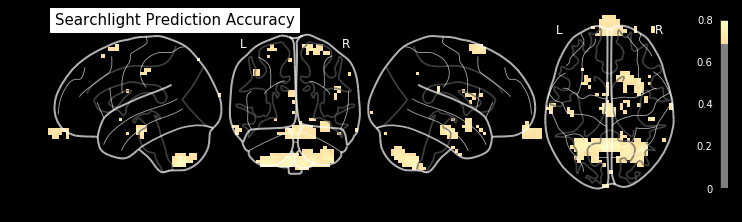

In [61]:
# First we need to put the searchlight output back into an MRI image
from nilearn.image import new_img_like
searchlight_img = new_img_like(func, sl.scores_)

from nilearn.plotting import plot_glass_brain
plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.7, cmap='magma', title='Searchlight Prediction Accuracy')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


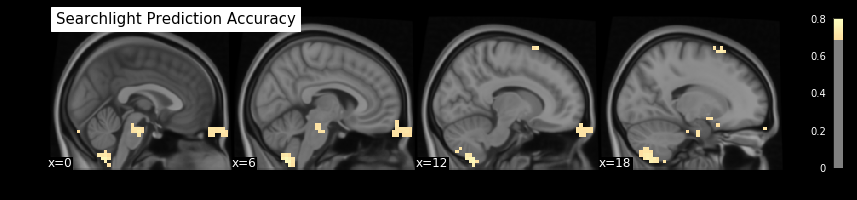

In [62]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.7, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

Keep in mind that we increased the minimum accuracy theshold in the two figures above to 70% (in the eye state analysis, this was at 60%). Therefore, whatever it means. It seems that male and female participant have different activation in the cerebellum, during resting-state fMRI.